# Python code

In [ ]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (20,10)
plt.style.use('fivethirtyeight')
from scipy.stats import skew, kurtosis
import matplotlib.image as mpimg
import ipywidgets as widgets
from IPython.display import display, clear_output

# XGBoost Classifier & RandomForestClassifier
from xgboost import XGBClassifier, plot_importance, Booster, plot_tree, to_graphviz, DMatrix
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

# Preprocessing & Cross validation
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit, cross_val_score, GridSearchCV

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix


L'objectif de cette section est de mesurer votre capacité à:
- Extraire des données, les visualiser, les interpreter
- Maitriser les concepts utilisés
- Construire un modèle prédictif
- Mesurer votre prise d'initiative

Le fichier *Nasdaq.xlsx* résume les valeurs journalières de l'indice du 5 février 1971 au 19 janvier 2022.

In [ ]:
# Load file
df = pd.read_excel('nasdaq.xlsx', index_col=0, parse_dates=True)[['Adj Close']]
# Calculate returns
df['Returns'] = np.log(df).diff()
df['Ret_1M'] = df['Returns'].rolling(20).sum()
# Output first five values
df.head()

,Adj Close,Returns,Ret_1M
Date,,,
1971-02-05,100.000000,NaN,NaN
1971-02-08,100.839996,0.008365,NaN
1971-02-09,100.760002,-0.000794,NaN
1971-02-10,100.690002,-0.000695,NaN
1971-02-11,101.449997,0.007520,NaN


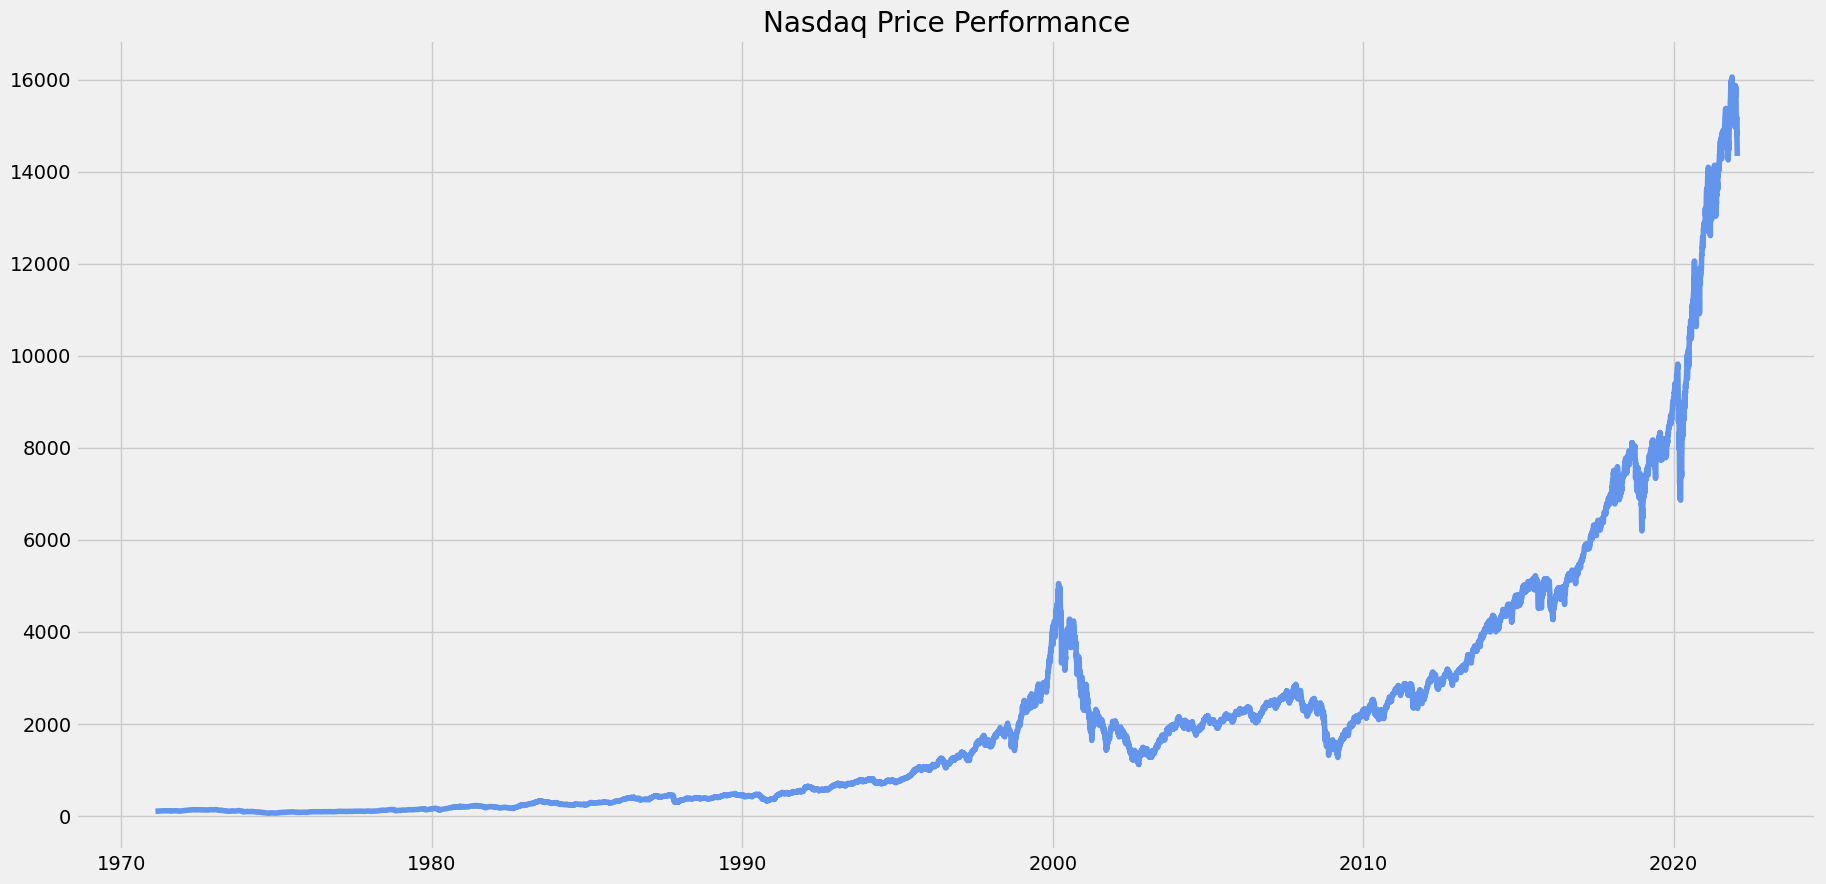

In [ ]:
# Visualize raw price series
plt.plot(df['Adj Close'], color='cornflowerblue')
plt.title('Nasdaq Price Performance');

**Observations :**

- Une **croissance exponentielle** des prix à long terme, indiquant une augmentation significative de la valeur du marché technologique au fil des décennies.

- Des périodes de **volatilité marquée**, comme la bulle Internet autour de l'an 2000, la crise financière de 2008 et l'impact de la pandémie de COVID-19 en 2020. Ces moments correspondent à des chutes brusques suivies de reprises, souvent caractéristiques de grands événements économiques.





## Statistiques


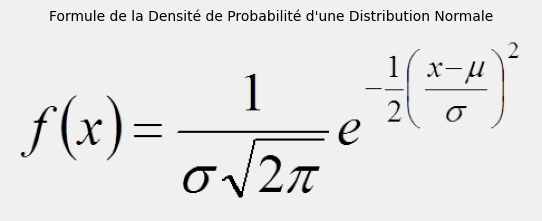

In [ ]:
image_path = "DENSITE_NORMALE.png"
img = mpimg.imread(image_path)
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis('off')
plt.title("Formule de la Densité de Probabilité d'une Distribution Normale", fontsize=10)
plt.show()


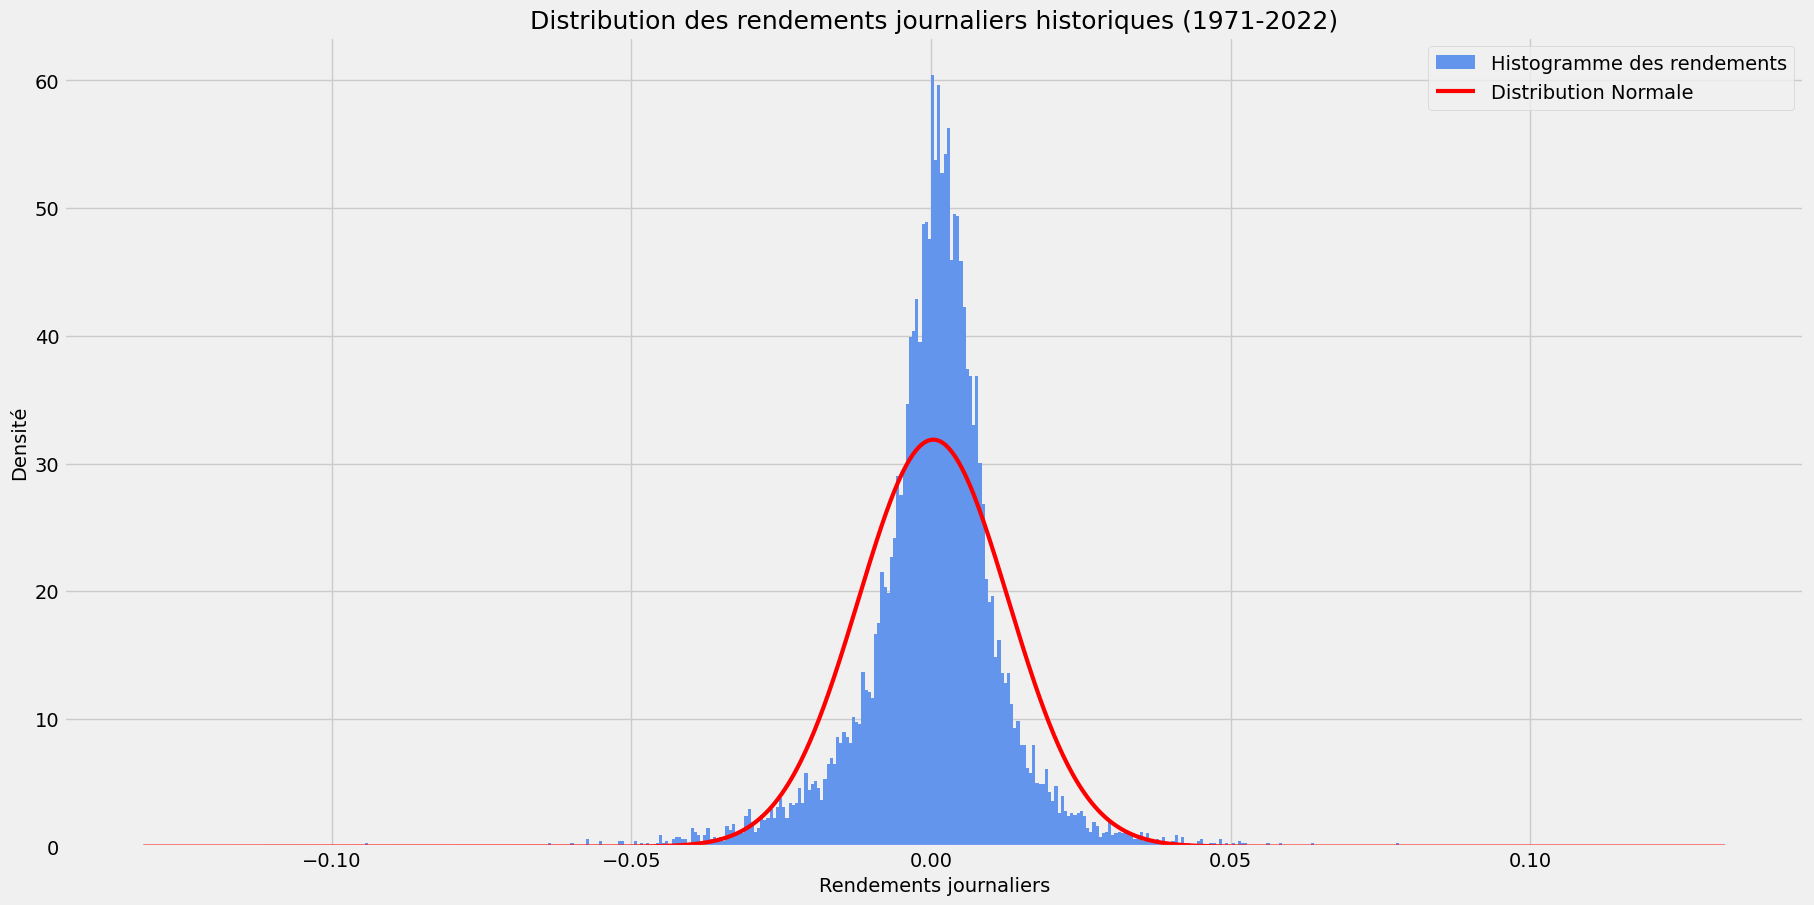

In [ ]:
# Commençons par tracer l'histogramme historique de 1971 à 2022

fig, ax = plt.subplots(figsize=(20, 10))
ax.hist(df['Returns'], bins=500, density=True, color='cornflowerblue', label='Histogramme des rendements')
ax.set_title("Distribution des rendements journaliers historiques (1971-2022)", fontsize=18)
ax.set_xlabel("Rendements journaliers", fontsize=14)
ax.set_ylabel("Densité", fontsize=14)
ax.grid(True)


# Completons maintenant avec la distrbution normale associe

mu = df['Returns'].mean() # La moyenne
sigma = df['Returns'].std() # L'écart-type
x = np.linspace(df['Returns'].min(), df['Returns'].max(), 1000) # Les valeurs des rendements
densite_proba_normale = (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*((x-mu)/sigma)**2)

plt.plot(x, densite_proba_normale, 'red', lw=3, label=f'Distribution Normale')
ax.legend(fontsize=14)
plt.show()

**Vérification de la Normalité à l'aide de la Skewness et de la Kurtosis**

Pour évaluer si les variables suivent une distribution normale, nous utilisons deux mesures statistiques : la **skewness** (asymétrie) et la **kurtosis** (aplatissement).

---

**Skewness (Asymétrie)**
- Mesure la symétrie de la distribution.
  - Skewness proche de 0 : distribution symétrique.
  - Skewness négative : distribution étirée à gauche.
  - Skewness positive : distribution étirée à droite.
- **Seuils** :
  - Normale : entre -1 et +1.
  - Acceptable : entre -2 et +2.

---

**Kurtosis (Aplatissement)**
- Mesure le degré de concentration des données autour de la moyenne.
  - Kurtosis positive : distribution pointue (leptokurtique).
  - Kurtosis négative : distribution plate (platykurtique).
- **Seuils** :
  - Normale : entre -2 et +2.

---

**Vérification et Résultats**
Une distribution normale est caractérisée par :
- Skewness entre -1 et +1.
- Kurtosis entre -2 et +2.

Les valeurs hors de ces seuils peuvent nécessiter des transformations (logarithmique, racine carrée, etc.) avant l'analyse.

---

**Source**
- Hair, J. F., et al. (2022). *Multivariate Data Analysis*.
- Documentation Python : `scipy.stats` et `pandas`.


In [ ]:
def evaluate_distribution(data):

    for column in data.select_dtypes(include=['float', 'int']).columns:
        col_skewness = skew(data[column].dropna())  # Skewness
        col_kurtosis = kurtosis(data[column].dropna(), fisher=True)  # Kurtosis

        if -1 <= col_skewness <= 1 and -2 <= col_kurtosis <= 2:
            suggested_distribution = "Normale"
        elif col_kurtosis > 3:
            suggested_distribution = "t de Student"
        elif col_skewness > 1 or col_skewness < -1:
            suggested_distribution = "Gamma ou Beta"
        else:
            suggested_distribution = "Autre"

        print(f"Variable: {column}")
        print(f"  Skewness: {col_skewness:.4f}")
        print(f"  Kurtosis: {col_kurtosis:.4f}")
        print(f"  Distribution Recommandée: {suggested_distribution}")
        print("-" * 50)

In [ ]:
evaluate_distribution(df)

Variable: Adj Close
  Skewness: 2.3682
  Kurtosis: 6.2977
  Distribution Recommandée: t de Student
--------------------------------------------------
Variable: Returns
  Skewness: -0.3860
  Kurtosis: 10.2488
  Distribution Recommandée: t de Student
--------------------------------------------------
Variable: Ret_1M
  Skewness: -0.9772
  Kurtosis: 4.1430
  Distribution Recommandée: t de Student
--------------------------------------------------


La distribution recommandée serait ici t de Student (queues épaisses).

## Modèle predictif - Classification

La variable cible est également connue sous le nom de variable dépendante. Ici, la variable cible est de savoir si le cours du Nasdaq clôturera à la hausse ou à la baisse le mois suivant. Si le cours de clôture dans un mois est supérieur d'au moins 5% au cours de clôture d'aujourd'hui, nous achèterons le Nasdaq, sinon nous le vendrons.

Nous attribuons une valeur de +1 pour le signal d'achat et de 0 sinon à la variable cible. L'objectif peut être décrit comme suit :
$$
y_t = \left\{
    \begin{array}{ll}
        1 & \mbox{if } p_{t+1} > 1.05 \times p_t\\
        0 & \mbox{ otherwise}
    \end{array}
\right.
$$
avec $p_t$ le prix de cloture du Nasdaq à date d'aujourd'hui et $p_{t+1}$ le prix de cloture du Nasdaq dans un mois.



### Inofrmations à savoir pour comprendre pourquoi on a pas tout les jours dans le dataset

---

1. Dates Clés

 **Liquidation** :
- Date : 4ème jour boursier avant la fin du mois M+1.
- Importance : Marque la fin de la période où la performance mensuelle est mesurée pour calculer la variable cible.

 **Premier jour de négociation** :
- Date : 3ème jour boursier avant la fin du mois M.
- Importance : Point de départ pour structurer les données d’entraînement.
**Règlement Livraison** :
- Date : Dernier jour de bourse du mois M+1.
- Importance : Représente la date limite pour évaluer la performance mensuelle du Nasdaq.

---

2. Mois Boursier

Le **mois boursier** commence le 4ème jour de bourse avant la fin du mois courant (M) et se termine le 5ème jour de bourse avant la fin du mois suivant (M+1).

- Cette période est utilisée pour évaluer si le Nasdaq a clôturé à la hausse ou à la baisse par rapport au seuil de 5 % pour la création de la variable cible.

---


5. Source

Ces informations sont adaptées des spécifications fournies par **Boursorama Bank**.

Lien : [Boursorama Bank - SRD](https://www.boursobank.com/aide-en-ligne/bourse/comment-ca-marche/investir-au-srd/question/quelles-sont-les-dates-a-retenir-lorsqu-on-investit-au-srd-6#:~:text=Entre%20le%20d%C3%A9but%20de%20la,fin%20du%20mois%20calendaire%20suivant.)


#### 1. Nettoyage des Données

Avant de transformer les données, il est important de vérifier :
- **Présence de valeurs manquantes (`NaN`)** : Identifier combien de lignes contiennent des valeurs manquantes.
- **Valeurs illogiques** : Par exemple, des prix négatifs ou des écarts extrêmes.
- Utilisation de méthodes comme `.info()` pour évaluer la structure des données et `.isna().sum()` pour compter les `NaN`.






In [ ]:
# Suppression des lignes vides
initial_rows = df.shape[0]
df = df.dropna()
final_rows = df.shape[0]

print(f"\nNettoyage effectué : {initial_rows - final_rows} lignes supprimées pour valeurs manquantes.")


Nettoyage effectué : 20 lignes supprimées pour valeurs manquantes.


In [ ]:
print("Structure et aperçu des données :")
df.info()

print("\nAperçu des valeurs manquantes :")
print(df.isna().sum())

print("\nStatistiques descriptives :")
print(df.describe())

Structure et aperçu des données :
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12832 entries, 1971-03-08 to 2022-01-19
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  12832 non-null  float64
 1   Returns    12832 non-null  float64
 2   Ret_1M     12832 non-null  float64
dtypes: float64(3)
memory usage: 401.0 KB

Aperçu des valeurs manquantes :
Adj Close    0
Returns      0
Ret_1M       0
dtype: int64

Statistiques descriptives :
          Adj Close       Returns        Ret_1M
count  12832.000000  12832.000000  12832.000000
mean    2151.788688      0.000385      0.007818
std     2870.517635      0.012526      0.059826
min       54.869999     -0.131492     -0.420089
25%      251.687500     -0.004468     -0.021097
50%     1180.434998      0.001079      0.013819
75%     2607.257568      0.006113      0.043226
max    16057.440430      0.132546      0.283159


In [ ]:
# Détectons des valeurs aberrantes
q1 = df['Adj Close'].quantile(0.25)
q3 = df['Adj Close'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df[(df['Adj Close'] < lower_bound) | (df['Adj Close'] > upper_bound)]
if not outliers.empty:
    print(f"\nAttention : {len(outliers)} lignes contiennent des valeurs aberrantes (outliers).")
    print(outliers[['Adj Close']].head())
else:
    print("\nAucune valeur aberrante détectée dans 'Adj Close'.")


Attention : 1172 lignes contiennent des valeurs aberrantes (outliers).
              Adj Close
Date                   
2017-05-15  6149.669922
2017-05-16  6169.870117
2017-05-24  6163.020020
2017-05-25  6205.259766
2017-05-26  6210.189941


##### Pourquoi les "Outliers" Observés Ne Sont Pas Anormaux ?

**1. Évolution Naturelle des Marchés**
- Les niveaux élevés de l'indice Nasdaq dans les années récentes (par exemple, en 2017) reflètent une **croissance structurelle normale** du marché entre 1971 et 2022.
- Cette augmentation est due à des facteurs économiques à long terme tels que l'inflation, l'innovation technologique, et l'expansion globale des marchés.

---
**2. Méthodes d'Identification des Outliers**
- Les outils statistiques (comme l'IQR ou les scores Z) détectent ces valeurs comme des "outliers" car ils supposent une stationnarité des données (pas de tendance à long terme).
- Or, les données du Nasdaq ne sont **pas stationnaires**, car elles suivent une tendance haussière structurelle.

---

**3. Pourquoi Ces Points Ne Sont Pas Anormaux**
- Ces "outliers" ne sont pas des anomalies, mais des résultats normaux de l'évolution historique du marché.
- Supprimer ces points serait une erreur, car ils sont représentatifs des niveaux actuels du marché.



In [ ]:
if (df['Adj Close'] < 0).any():
    print("Attention : Certaines valeurs dans 'Adj Close' sont négatives.")
else:
    print("Aucune valeur négative détectée dans 'Adj Close'.")

Aucune valeur négative détectée dans 'Adj Close'.


#### 2. Moyennes Mobiles (MA) et Volatilité

Deux indicateurs techniques clés sont calculés sur des périodes de 10 et 50 jours :

- **Moyennes Mobiles (MA)** :
  - Elles représentent la moyenne des prix de clôture sur une période donnée.
  - Ces moyennes mobiles permettent de détecter les tendances à court et long termes.

- **Volatilité** :
  - Calculée comme l’écart-type des prix de clôture sur une période donnée.
  - Elle mesure les fluctuations des prix, indiquant les périodes de forte instabilité ou de stabilité relative.

**Sources :**
- [FasterCapital - Moyennes Mobiles et Volatilité : Analyse des oscillations de prix](https://fastercapital.com/fr/contenu/Moyennes-mobiles-et-volatilite--analyse-des-oscillations-de-prix.html?utm_source=chatgpt.com)
- [Rankia - La Moyenne Mobile SMA, EMA et WMA : Formules et Exemples](https://rankia.fr/la-moyenne-mobile-sma-ema-et-wma-formules-et-exemples/?utm_source=chatgpt.com)


In [ ]:
for window in [10, 50]:
    df[f'MA_{window}'] = df['Adj Close'].rolling(window=window).mean()
    df[f'Volatility_{window}'] = df['Adj Close'].rolling(window=window).std()

#### 3. Bandes de Bollinger

Les bandes de Bollinger sont un indicateur technique développé par John Bollinger dans les années 1980. Elles sont constituées de trois lignes tracées sur un graphique de prix :

- **Bande supérieure** : moyenne mobile simple sur une période donnée (généralement 20 jours) augmentée de deux écarts-types.
- **Bande inférieure** : moyenne mobile simple diminuée de deux écarts-types.
- **Bande médiane** : moyenne mobile simple sur la même période.

Ces bandes s'ajustent en fonction de la volatilité du marché : elles s'élargissent lorsque la volatilité augmente et se resserrent lorsqu'elle diminue. Les bandes de Bollinger aident à identifier les niveaux de surachat (lorsque le prix atteint ou dépasse la bande supérieure) et de survente (lorsque le prix atteint ou tombe en dessous de la bande inférieure). :contentReference[oaicite:0]{index=0}

**Sources :**
- [Finance Héros - Bandes de Bollinger : utilisation & interprétation](https://finance-heros.fr/bande-de-bollinger/)
- [Journal du Net - Bandes de Bollinger : définition et utilisation](https://www.journaldunet.fr/patrimoine/guide-des-finances-personnelles/1504257-bandes-de-bollinger-definition-et-utilisation/)
- [IG - Bandes de Bollinger - définition](https://www.ig.com/fr/glossaire-trading/bandes-de-bollinger-definition)
- [Café de la Bourse - Bandes de Bollinger : comment les utiliser en Bourse](https://www.cafedelabourse.com/actualites/bandes-de-bollinger-en-bourse)


In [ ]:
df['MA_20'] = df['Adj Close'].rolling(window=20).mean()
df['Bollinger_Upper'] = df['MA_20'] + 2 * df['Adj Close'].rolling(window=20).std()
df['Bollinger_Lower'] = df['MA_20'] - 2 * df['Adj Close'].rolling(window=20).std()

#### 4. Average True Range (ATR)

L'**Average True Range (ATR)** est un indicateur technique développé par J. Welles Wilder en 1978, qui mesure la volatilité des prix d'un actif financier. Il prend en compte les fluctuations quotidiennes des prix, notamment :

- L'écart entre les prix les plus hauts et les plus bas d'une journée.
- Les différences entre les prix de clôture d'un jour à l'autre.

Calculé généralement sur une période de 14 jours, l'ATR fournit une estimation de la volatilité réelle du marché. Une valeur élevée de l'ATR indique une forte volatilité, tandis qu'une valeur faible suggère une volatilité moindre. :contentReference[oaicite:0]{index=0}

**Sources :**
- [Rankia - Qu’est-ce que l’Average True Range (ATR) et comment l’utiliser](https://rankia.fr/atr-average-true-range/)
- [Trading Finance - Comprendre l’Average True Range : Guide détaillé de l’indicateur ATR](https://www.tradingfinance.fr/comprendre-indicateur-average-true-range-atr-explications-utilisation/)
- [Arya Trading - Comment Utiliser l’Indicateur Average True Range (ATR)](https://www.aryatrading.com/blog/average-true-range)



In [ ]:
df['High-Low'] = df['Adj Close'] * 0.02
df['High-Close'] = abs(df['Adj Close'] * 1.02 - df['Adj Close'].shift(1))
df['Low-Close'] = abs(df['Adj Close'] * 0.98 - df['Adj Close'].shift(1))
df['ATR'] = df[['High-Low', 'High-Close', 'Low-Close']].max(axis=1).rolling(window=14).mean()

##### **1. `df['High-Low'] = df['Adj Close'] * 0.02`**
- Cette ligne calcule une **approximation** de l'écart entre les prix les plus hauts et les plus bas d’une journée.
- Elle utilise une variation estimée à **±2 %** du prix de clôture ajusté (`Adj Close`) pour simuler la différence entre le prix haut et le prix bas.

---

##### **2. `df['High-Close'] = abs(df['Adj Close'] * 1.02 - df['Adj Close'].shift(1))`**
- Cette ligne calcule la différence absolue entre :
  1. Le prix **haut** de la journée actuelle (approximé par \( \text{Adj Close} \times 1.02 \)).
  2. Le **prix de clôture de la veille** (décalé avec `shift(1)`).
- **Objectif** : Capturer les moments où le prix haut dépasse significativement le prix de clôture précédent.

---

##### **3. `df['Low-Close'] = abs(df['Adj Close'] * 0.98 - df['Adj Close'].shift(1))`**
- Cette ligne calcule la différence absolue entre :
  1. Le prix **bas** de la journée actuelle (approximé par \( \text{Adj Close} \times 0.98 \)).
  2. Le **prix de clôture de la veille** (décalé avec `shift(1)`).
- **Objectif** : Capturer les moments où le prix bas est significativement inférieur au prix de clôture précédent.

---

##### **4. `df['ATR'] = df[['High-Low', 'High-Close', 'Low-Close']].max(axis=1).rolling(window=14).mean()`**
- **Étape 1** : Calcul du **True Range (TR)** :
  - Pour chaque jour, cette ligne détermine la plus grande valeur parmi :
    - `High-Low` : Fluctuation intra-journalière.
    - `High-Close` : Différence entre le prix haut et le prix de clôture de la veille.
    - `Low-Close` : Différence entre le prix bas et le prix de clôture de la veille.
- **Étape 2** : Calcul de l’**ATR (Average True Range)** :
  - Moyenne glissante sur une période de **14 jours** du True Range.
  - Cela lisse les variations journalières pour fournir une mesure stable et précise de la volatilité.



#### 5. Momentum

Le Momentum mesure la vitesse de variation des prix en calculant la différence entre le prix actuel et le prix d’il y a 10 jours. Cet indicateur est utile pour évaluer la force des mouvements de prix.

In [ ]:
df['Momentum'] = df['Adj Close'] - df['Adj Close'].shift(10)

#### 6. Relative Strength Index (RSI)

Le **Relative Strength Index (RSI)** est un indicateur technique développé par J. Welles Wilder en 1978. Il mesure la vitesse et l'ampleur des mouvements de prix récents pour évaluer les conditions de surachat ou de survente d'un actif. Calculé généralement sur une période de 14 jours, le RSI oscille entre 0 et 100 :

- Un RSI supérieur à 70 suggère que l'actif est **suracheté**, ce qui peut indiquer un potentiel retournement à la baisse.
- Un RSI inférieur à 30 suggère que l'actif est **survendu**, ce qui peut signaler un potentiel retournement à la hausse.

Cet indicateur aide les traders à identifier les points de retournement potentiels sur le marché. :contentReference[oaicite:0]{index=0}

**Sources :**
- [Café de la Bourse - Relative Strength Index (RSI) : Définition Bourse](https://www.cafedelabourse.com/lexique/definition/relative-strength-index-rsi)
- [Finance Mania - Qu'est-ce que le RSI (Relative Strength Index)](https://finance-mania.com/rsi/)
qu_est-ce-que-l_indicateur-rsi-et-comment-lutiliser-en-trading---230511)
- [Lynx Broker - Comment bien utiliser l'indicateur RSI](https://www.lynxbroker.fr/bourse/trading/analyse-technique/indicateurs-techniques/indicateur-rsi/)


In [ ]:
delta = df['Adj Close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
df['RSI'] = 100 - (100 / (1 + (avg_gain / avg_loss)))

In [ ]:
features = [f'MA_{window}' for window in [10, 50]] + \
           [f'Volatility_{window}' for window in [10, 50]] + \
           ['Bollinger_Upper', 'Bollinger_Lower', 'ATR', 'Momentum', 'RSI']

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12832 entries, 1971-03-08 to 2022-01-19
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Adj Close        12832 non-null  float64
 1   Returns          12832 non-null  float64
 2   Ret_1M           12832 non-null  float64
 3   MA_10            12823 non-null  float64
 4   Volatility_10    12823 non-null  float64
 5   MA_50            12783 non-null  float64
 6   Volatility_50    12783 non-null  float64
 7   MA_20            12813 non-null  float64
 8   Bollinger_Upper  12813 non-null  float64
 9   Bollinger_Lower  12813 non-null  float64
 10  High-Low         12832 non-null  float64
 11  High-Close       12831 non-null  float64
 12  Low-Close        12831 non-null  float64
 13  ATR              12819 non-null  float64
 14  Momentum         12822 non-null  float64
 15  RSI              12819 non-null  float64
dtypes: float64(16)
memory usage: 1.7 MB


Analysez et commentez les corrélations entre vos différentes variables independantes

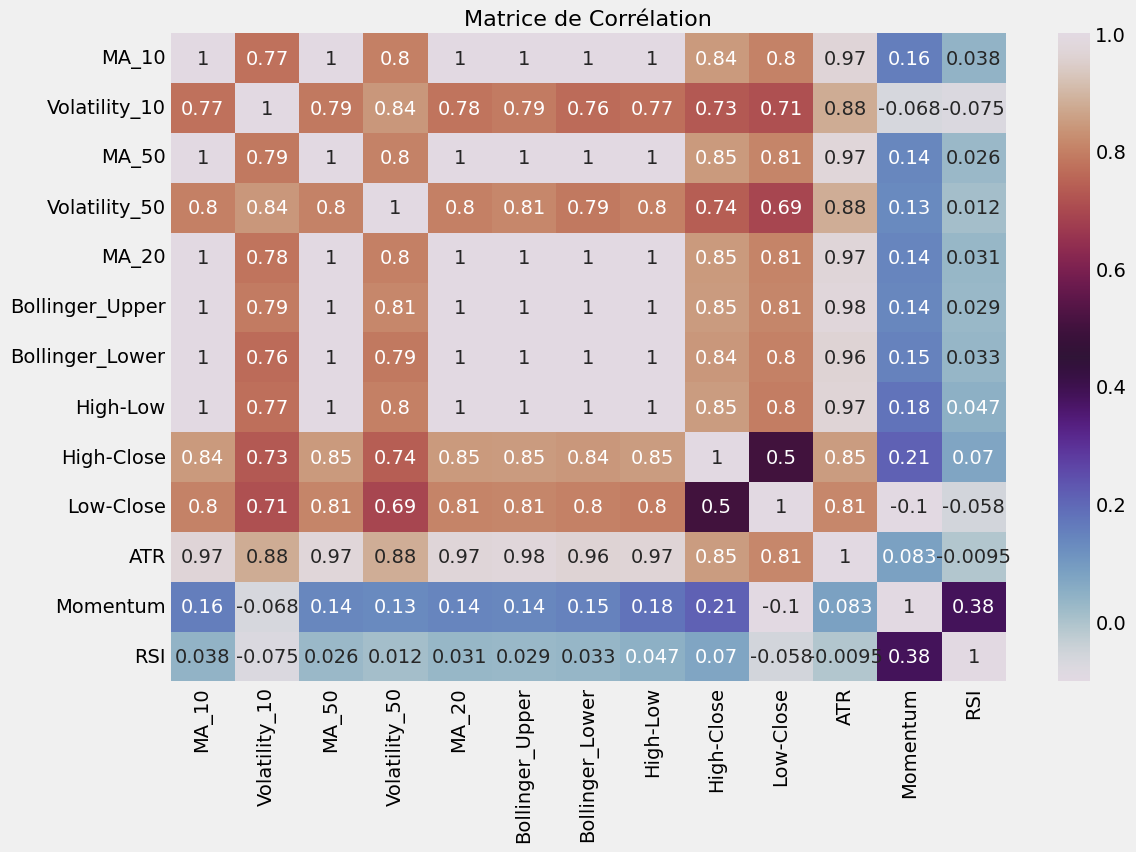

In [ ]:
correlation_matrix = df[[
    'MA_10', 'Volatility_10', 'MA_50', 'Volatility_50',
    'MA_20', 'Bollinger_Upper', 'Bollinger_Lower',
    'High-Low', 'High-Close', 'Low-Close', 'ATR', 'Momentum', 'RSI']].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot = True, cmap = 'twilight')
plt.title("Matrice de Corrélation", fontsize=16)
plt.show()

**Observations et Interprétations de la Matrice de Corrélation**

1. **Variables fortement corrélées**
   - Les moyennes mobiles **MA_10**, **MA_50** et **MA_20** montrent une forte corrélation (proche de 1) entre elles, ainsi qu’avec **Bollinger_Upper**, **Bollinger_Lower** et **ATR**.
     - **Interprétation** : Ces variables sont redondantes et représentent des informations similaires sur les tendances des prix. Nous pourrions envisager d’en conserver une ou deux pour réduire la multicolinéarité.

---

2. **Volatilité et ATR**
   - Les variables de volatilité (**Volatility_10** et **Volatility_50**) montrent une corrélation forte avec l’**ATR** (autour de **0.97** et **0.88** respectivement), ce qui est logique puisque l’ATR mesure également une forme de volatilité.
     - **Interprétation** : Ces variables apportent des informations complémentaires et peuvent être utiles ensemble pour capturer la volatilité réelle.

---

3. **Momentum et RSI**
   - Le **Momentum** et le **RSI** montrent des corrélations faibles ou modérées avec les autres variables :
     - **Momentum** a une corrélation de **0.38** avec le **RSI** mais reste peu lié aux autres variables.
     - **RSI** montre des corrélations très faibles avec toutes les autres (proches de 0), indiquant qu’il apporte une information unique.
     - **Interprétation** : Ces variables capturent des dynamiques différentes et sont utiles pour enrichir le modèle.

---

4. **High-Close, Low-Close et High-Low**
   - Les variables **High-Close**, **Low-Close** et **High-Low** présentent des corrélations modérées avec les moyennes mobiles et l’ATR :
     - Cela indique qu'elles capturent des aspects des fluctuations journalières et des gaps, mais restent liées aux tendances générales des prix.
     - **Interprétation** : Nous pourrions les conserver si elles apportent une meilleure performance au modèle.

---

**Conclusion**

En résumé, nous pouvons choisir les features suivantes pour construire le modèle :
- **MA_10**
- **Volatility_10**
- **Momentum**
- **RSI**
- **ATR**
- **High-Close** (ou **Low-Close**, selon la performance observée dans le modèle).


In [ ]:
features = ['MA_10', 'Volatility_10', 'Bollinger_Upper', 'ATR', 'Momentum', 'RSI']

### Definition de la variable dependante


**Réflexions sur la Définition de la Variable Cible**

 **1. Première Idée : Utilisation d'un Shift de 20 Jours**
Au départ, dans le code initial fourni par le jury, la colonne **Ret_1M** a été créée en utilisant un décalage fixe de **20 jours boursiers**. Cette méthode, bien que pratique, repose sur l'hypothèse que chaque mois boursier comporte environ 20 jours de trading, en excluant les week-ends et les jours fériés. Cette approche permet de comparer les rendements cumulés sur une période de 20 jours boursiers pour identifier les variations du marché sur un "mois" standardisé.

**Autre proposition :**

- Certains mois boursiers peuvent comporter moins de 20 jours (par exemple, février ou des mois comportant plusieurs jours fériés).
- D'autres mois peuvent en comporter davantage (par exemple, mars ou juillet).

Ces écarts peuvent introduire un **biais**, notamment si des variations importantes se produisent à la fin ou au début d'un mois particulier. Une réflexion plus approfondie m'a conduit à envisager une approche dynamique prenant en compte les **mois calendaires exacts** pour une meilleure précision.


---

 **2. Deuxième Idée : L'Idée d'une Méthode Dynamique Basée sur les Mois Réels**
J'ai réfléchi à une méthode où le décalage ne serait pas fixe, mais plutôt basé sur les **mois calendaires exacts** présents dans l'index. L'idée était d'identifier le dernier jour boursier de chaque mois et d'utiliser cette information pour représenter "un mois" dans la comparaison des prix. Par exemple :
- Si septembre 2000 compte 23 jours boursiers, je considérerais un décalage de 23 jours.
- Cette méthode garantirait que la variable cible reflète précisément les variations calendairement définies.

**Avantages :**
- Respecte les périodes économiques ou financières calendairement significatives.
- Réduit les biais introduits par des approximations fixes.

---

 **3. Troisième Idée : Simplification grâce aux Jours Boursiers Déjà Présents dans l'Index**
En étudiant davantage le dataset, j'ai remarqué que l'index contient **uniquement les jours boursiers**, ce qui exclut déjà les week-ends et les jours fériés. Cela rend l'utilisation d'un décalage fixe de 20 jours raisonnable, car les jours non boursiers sont déjà absents.

**Conclusion Intermédiaire :**
- Si je privilégie la simplicité et que je ne cherche pas à aligner strictement les périodes sur des mois calendaires, l'approche avec un décalage fixe de 20 jours peut suffire.
- Cependant, si une analyse fine basée sur des périodes économiques spécifiques est nécessaire, l'approche dynamique basée sur les mois est préférable.

---

 **4. Décision Finale**
Après réflexion, je réalise que le choix entre un décalage fixe et une méthode dynamique dépend de l'objectif de l'analyse :
1. **Décalage fixe de 20 jours** : Approprié pour une approche rapide et pratique.
2. **Méthode basée sur les mois réels** : Plus précise, surtout si l'on souhaite aligner les résultats sur des périodes calendairement significatives.

Pour ce projet, je choisirais l'approche dynamique si l'objectif est d'aligner strictement les décisions sur des périodes mensuelles. Si ce niveau de précision n'est pas nécessaire, l'utilisation de 20 jours reste une solution efficace et plus simple à implémenter.


In [ ]:
# Dans le cas ou on choisirais un décalage fixe de 20 jours
#df['Next_Month'] = df['Adj Close'].shift(-20)
#df['Target'] = (df['Next_Month'] > 1.05 * df['Adj Close']).astype(int)
#target = 'Target'

In [ ]:
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Last_Trading_Day'] = df.groupby(['Year', 'Month'])['Adj Close'].transform('last')
df['Next_Month'] = df.groupby(['Year', 'Month'])['Last_Trading_Day'].shift(-1)
df['Target'] = (df['Next_Month'] > 1.05 * df['Adj Close']).astype(int)
df.drop(columns=['Year', 'Month', 'Last_Trading_Day'], inplace=True)
target = 'Target'


In [ ]:
df

,Adj Close,Returns,Ret_1M,MA_10,Volatility_10,MA_50,Volatility_50,MA_20,Bollinger_Upper,Bollinger_Lower,High-Low,High-Close,Low-Close,ATR,Momentum,RSI,Next_Month,Target
Date,,,,,,,,,,,,,,,,,,
1971-03-08,104.230003,0.011871,0.041430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.084600,NaN,NaN,NaN,NaN,NaN,105.970001,0
1971-03-09,104.410004,0.001725,0.034790,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.088200,2.268201,1.908199,NaN,NaN,NaN,105.970001,0
1971-03-10,104.139999,-0.002589,0.032995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.082800,1.812795,2.352805,NaN,NaN,NaN,105.970001,0
1971-03-11,104.260002,0.001152,0.034841,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.085200,2.205203,1.965197,NaN,NaN,NaN,105.970001,0
1971-03-12,104.500000,0.002299,0.029621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.090000,2.329998,1.850002,NaN,NaN,NaN,105.970001,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-12,15188.389650,0.002303,-0.003237,15324.364943,346.104185,15576.245782,320.721049,15403.791408,16056.516040,14751.066776,303.767793,338.707243,268.828343,445.657378,-577.83008,41.282773,14340.259770,0
2022-01-13,14806.809570,-0.025444,-0.049975,15230.889943,347.135807,15559.389981,338.444309,15365.852883,16065.500910,14666.204855,296.136191,85.443889,677.716271,462.312264,-934.75000,30.430676,14340.259770,0
2022-01-14,14893.750000,0.005854,-0.019065,15155.767970,328.345614,15541.033380,349.206431,15351.518898,16078.379499,14624.658297,297.875000,384.815430,210.934570,451.562306,-751.21973,25.947449,14340.259770,0


### Interprétation de la Colonne `Target`

La colonne `Target` indique si le prix du Nasdaq augmente de **5 % ou plus** dans un mois boursier par rapport à la date actuelle. Ici, **un mois** est défini comme le **nombre exact de jours boursiers du mois suivant**. Cette approche permet de répondre à la question : "Le Nasdaq atteindra-t-il une hausse de 5 % ou plus dans le mois à venir ?" Voici un exemple :

- **Date : 8 mars 1971**
  - **Prix de clôture (Adj Close)** : `104.23`.
  - **Prix de clôture au dernier jour boursier du mois suivant (Next_Month)** : `105.97`.
  - **Variation en pourcentage** : \(((105.97 - 104.23) / 104.23) \times 100 \approx 1.67\%\).

La variation étant inférieure au seuil de **5 %**, la colonne `Target` est égale à **0**, indiquant qu'il n'y a **pas d'achat recommandé** pour cette date.

---

### Pourquoi le mois suivant ?

Cette approche est basée sur le mois suivant pour respecter la logique prédictive :
- La variable cible doit évaluer une **variation future**, et non une variation déjà réalisée (mois précédent).
- Le calcul compare donc le prix actuel à celui du **dernier jour boursier du mois suivant**, pour déterminer si une augmentation de 5 % ou plus est atteinte.

Ce calcul est répété pour chaque ligne du dataset afin d'évaluer les opportunités d'achat ou non.


### Construction du modèle predictif


Nous allons utiliser ici le modèle XGBoost, cependant vous pouvez trouver dans la partie Bonus, la version avec RandomnForest et une comparaison des métriques afin de déterminer quel modèle est plus plus efficace

In [ ]:
metrics_results = {}

X = df[['MA_10', 'Volatility_10', 'Bollinger_Upper', 'ATR', 'Momentum', 'RSI']]
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]

metrics_results["Baseline"] = {
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1-Score": f1_score(y_test, y_pred),
    "AUC-ROC": roc_auc_score(y_test, y_proba)
}


<Figure size 400x400 with 0 Axes>

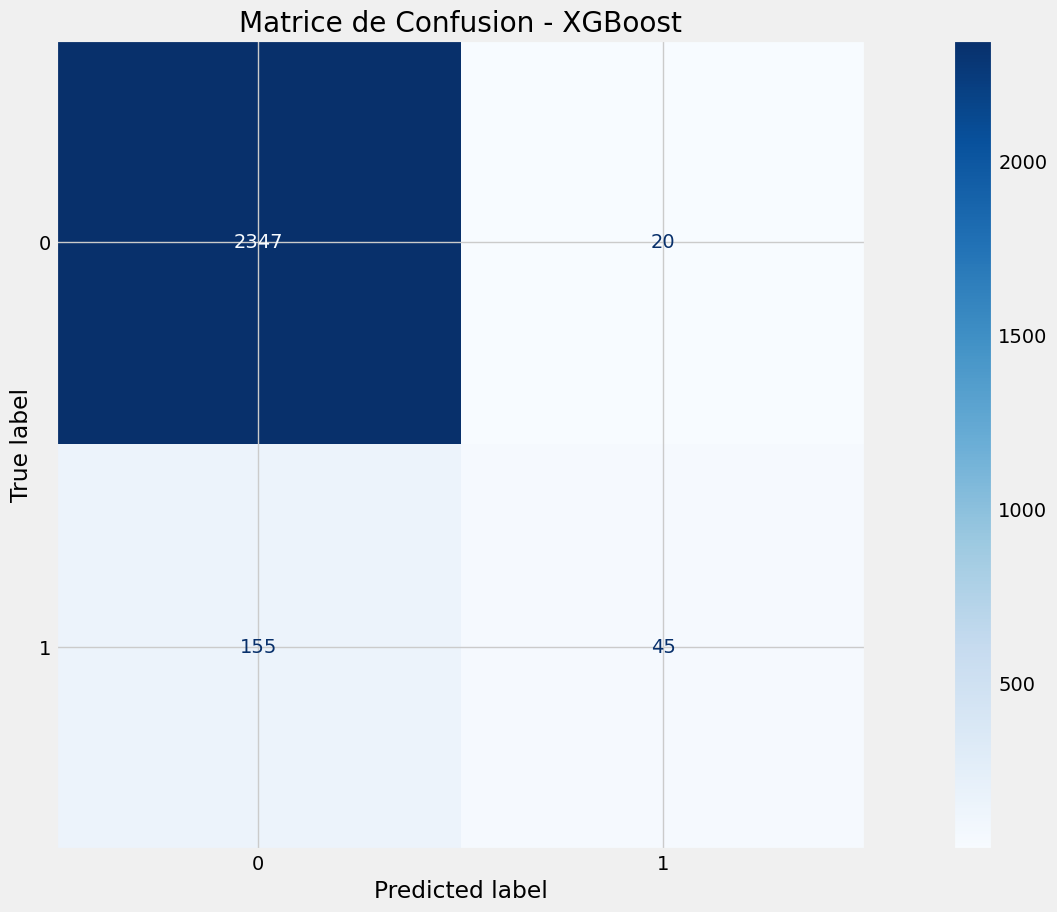

Précision: 0.69
Rappel: 0.23
F1-Score: 0.34
AUC-ROC: 0.88


In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model.classes_)
disp.plot(cmap="Blues")
plt.title("Matrice de Confusion - XGBoost")
plt.show()

precision = metrics_results["Baseline"]["Precision"]
recall = metrics_results["Baseline"]["Recall"]
f1 = metrics_results["Baseline"]["F1-Score"]
auc_roc = metrics_results["Baseline"]["AUC-ROC"]

print(f"Précision: {precision:.2f}")
print(f"Rappel: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"AUC-ROC: {auc_roc:.2f}")


**Analyse de la Matrice de Confusion et des Métriques de Performance (XGBoost)**

La matrice de confusion présente les performances du modèle XGBoost pour prédire si le Nasdaq clôturera à la hausse (+1) ou à la baisse (0) le mois suivant.

---

**Objectif**
Le modèle vise à prédire si le cours de clôture du Nasdaq augmentera d'au moins **5 %** dans un mois. Si cette condition est remplie, la stratégie suggère un achat du Nasdaq (label = +1), sinon une vente (label = 0).

---

** Mécanique des Métriques :**
- **Précision (0.69)** : Parmi toutes les prédictions positives (achats), **69 %** sont correctes.  
  - **Importance** : La précision est cruciale pour éviter les faux signaux d'achat inutiles.

- **Rappel (0.23)** : Parmi tous les cas où le Nasdaq aurait dû être à la hausse, seulement **23 %** ont été correctement identifiés.  
  - **Importance** : Un faible rappel signifie que de nombreuses opportunités d'achat potentielles sont manquées.

- **F1-Score (0.34)** : Moyenne harmonique entre précision et rappel. La faible valeur reflète un déséquilibre, où le modèle privilégie les prédictions sûres (précision) mais manque de nombreuses hausses potentielles (rappel).

- **AUC-ROC (0.88)** : Indique une capacité raisonnable à distinguer les hausses et baisses, bien qu'une AUC élevée contraste avec le faible rappel.

---

**Analyse des Résultats :**
- **Points Positifs** :
  - Une précision de **69 %** montre que les prédictions d'achat sont majoritairement fiables.
  - Une AUC-ROC de **0.88** indique que le modèle est globalement performant pour séparer les hausses des baisses.

- **Points Négatifs** :
  - Un rappel de **23 %** est extrêmement faible, indiquant que de nombreuses hausses significatives sont ignorées.
  - Le F1-Score de **34 %** illustre un déséquilibre important entre précision et rappel.

---

**Recommandations pour l'Optimisation :**
1. **Augmenter le Rappel** :
   - Abaisser le seuil de décision pour améliorer la détection des hausses potentielles (augmenter le rappel, même si cela peut réduire la précision).
   - Expérimenter des techniques de rééquilibrage des classes, comme le sur-échantillonnage des hausses.

2. **Réduire les Faux Positifs** :
   - Analyser les signaux caractéristiques des faux positifs pour améliorer la robustesse du modèle.
   - Ajouter de nouvelles variables explicatives ou explorer des modèles plus complexes.

3. **Ajuster les Hyperparamètres** :
   - Réévaluer les paramètres du modèle XGBoost via une recherche approfondie pour améliorer l'équilibre entre précision et rappel.


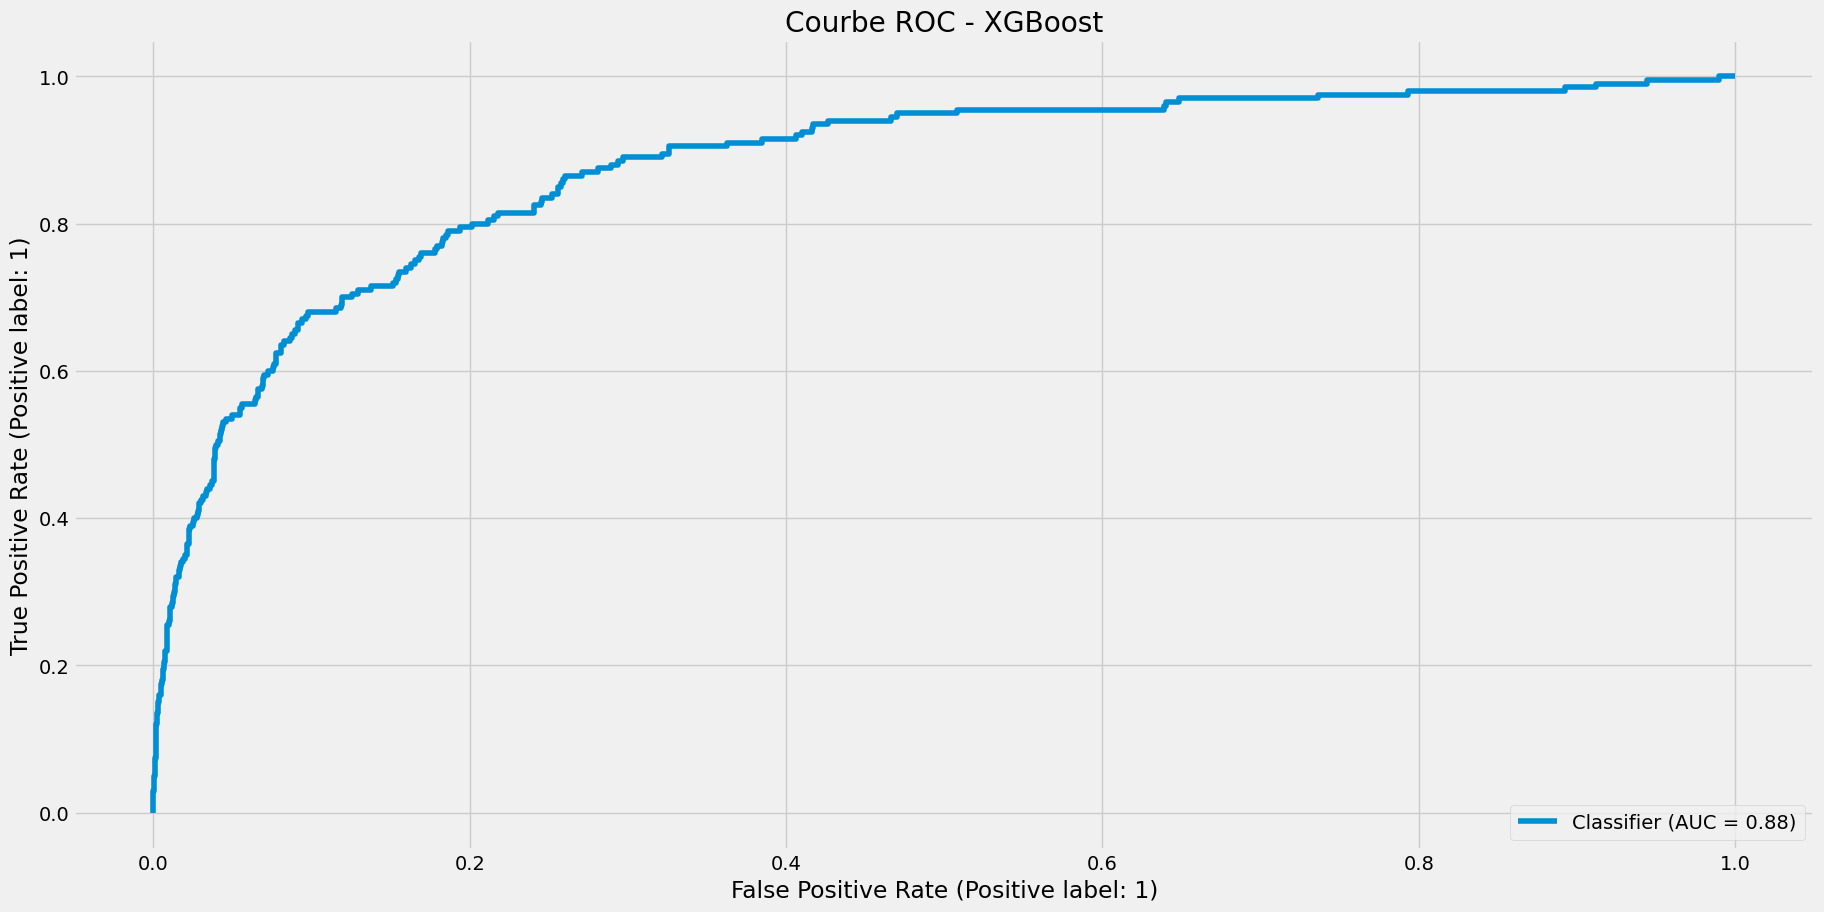

In [ ]:
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("Courbe ROC - XGBoost")
plt.show()


- Avec un AUC-ROC de 0.88, le modèle est performant et adapté pour prédire si nous devons acheter ou vendre le Nasdaq.
- Cela montre que les features sélectionnées (moyennes mobiles, RSI, ATR, etc.) apportent des informations utiles.

### Tuning des hyperparamètres


**Problème avec XGBoost et scikit-learn**

Dans l'environnement Google Colab, j'avais initialement :
- XGBoost : 2.1.3
- scikit-learn : 1.6.0

Une erreur est survenue lors de l'utilisation de `RandomizedSearchCV` avec `XGBClassifier`, liée à la méthode `__sklearn_tags__`. Ce problème provient d'une incompatibilité entre ces versions récentes.

**Solution : rétrogradation des versions**

J'ai rétrogradé les bibliothèques à des versions stables et compatibles :
- XGBoost : 1.6.0
- scikit-learn : 1.0.2


In [ ]:
#!pip install xgboost==2.0.0 scikit-learn==1.3.1
#!pip uninstall -y bigframes mlxtend


#### RandomizedSearchCV

In [ ]:
params = {
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "max_depth": [3, 4, 5, 6, 8],
    "min_child_weight": [1, 3, 5, 7],
    "gamma": [0, 0.1, 0.2, 0.3, 0.4],
    "colsample_bytree": [0.3, 0.4, 0.5, 0.7],
    "subsample": [0.5, 0.7, 0.8, 1.0],
    "n_estimators": [50, 100, 200, 300]
}

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=params,
    n_iter=50,
    scoring='accuracy',
    n_jobs=-1,
    cv=5,
    verbose=3,
    random_state=42
)

random_search.fit(X_train, y_train)
best_xgb_model_1 = random_search.best_estimator_

y_pred_1 = best_xgb_model_1.predict(X_test)
y_proba_1 = best_xgb_model_1.predict_proba(X_test)[:, 1]
auc_base = roc_auc_score(y_test, y_proba_1)


metrics_results["RandomizedSearch"] = {
    "Precision": precision_score(y_test, y_pred_1),
    "Recall": recall_score(y_test, y_pred_1),
    "F1-Score": f1_score(y_test, y_pred_1),
    "AUC-ROC": roc_auc_score(y_test, y_proba_1)
}


Fitting 5 folds for each of 50 candidates, totalling 250 fits


#### GridSearchCV

In [ ]:
param_grid = {
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": [3, 5, 7, 10],
    "min_child_weight": [1, 3, 5],
    "gamma": [0, 0.1, 0.2, 0.3],
    "colsample_bytree": [0.5, 0.7, 1.0],
    "n_estimators": [50, 100, 200]
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=-1,
    cv=5,
    verbose=3
)

grid_search.fit(X_train, y_train)
best_xgb_model = grid_search.best_estimator_

y_pred = best_xgb_model.predict(X_test)
y_proba = best_xgb_model.predict_proba(X_test)[:, 1]

metrics_results["GridSearch"] = {
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1-Score": f1_score(y_test, y_pred),
    "AUC-ROC": roc_auc_score(y_test, y_proba)
}


Fitting 5 folds for each of 1728 candidates, totalling 8640 fits


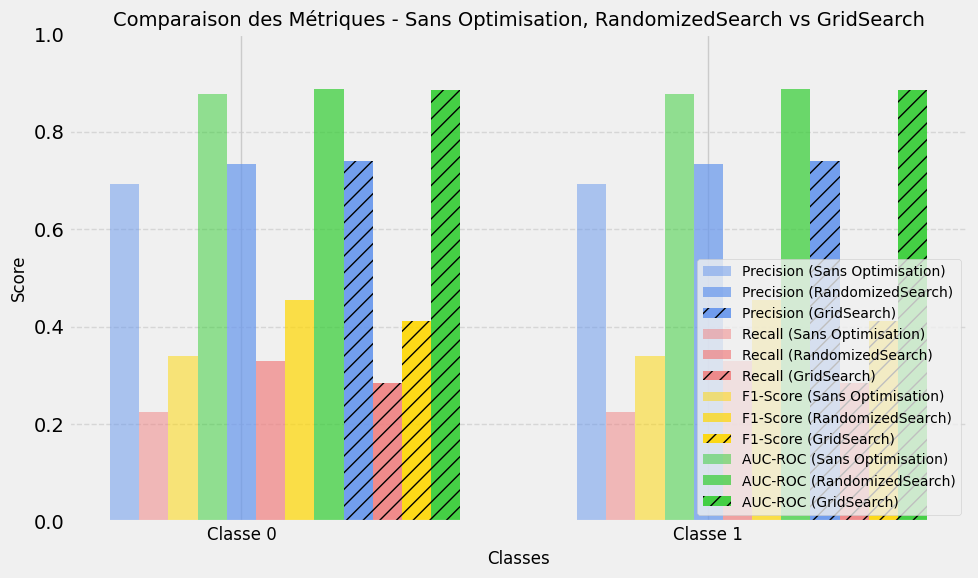

In [ ]:
classes = ['Classe 0', 'Classe 1']
x = np.arange(len(classes))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

for i, (metric, color) in enumerate(zip(['Precision', 'Recall', 'F1-Score', 'AUC-ROC'], ['cornflowerblue', 'lightcoral', 'gold', 'limegreen'])):
    baseline = [metrics_results["Baseline"][metric]] * len(classes)
    randomized = [metrics_results["RandomizedSearch"][metric]] * len(classes)
    grid = [metrics_results["GridSearch"][metric]] * len(classes)

    ax.bar(x - width + i*width/4, baseline, width/4, label=f"{metric} (Sans Optimisation)", color=color, alpha=0.5)
    ax.bar(x + i*width/4, randomized, width/4, label=f"{metric} (RandomizedSearch)", color=color, alpha=0.7)
    ax.bar(x + width + i*width/4, grid, width/4, label=f"{metric} (GridSearch)", color=color, alpha=0.9, hatch='//')

ax.set_xlabel("Classes", fontsize=12)
ax.set_ylabel("Score", fontsize=12)
ax.set_title("Comparaison des Métriques - Sans Optimisation, RandomizedSearch vs GridSearch", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(classes, fontsize=12)
ax.legend(loc="lower right", fontsize=10)
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
metrics_results

{'Baseline': {'Precision': 0.6923076923076923,
  'Recall': 0.225,
  'F1-Score': 0.339622641509434,
  'AUC-ROC': 0.8765948457963667},
 'RandomizedSearch': {'Precision': 0.7333333333333333,
  'Recall': 0.33,
  'F1-Score': 0.45517241379310347,
  'AUC-ROC': 0.8873531896915928},
 'GridSearch': {'Precision': 0.7402597402597403,
  'Recall': 0.285,
  'F1-Score': 0.411552346570397,
  'AUC-ROC': 0.8861005492184199}}

##### Interprétations

###### **Classe 0 (Pas d'achat - Majoritaire)**
- La **précision** de **89%** pour la classe 0 montre que le modèle identifie correctement la plupart des cas où il ne faut pas acheter.
- Le **rappel** de **96%** indique que le modèle capture presque tous les cas réels de "Pas d'achat".
- Le **F1-score** de **92%** reflète un excellent équilibre entre précision et rappel pour cette classe.

###### **Classe 1 (Acheter - Minoritaire)**
- La **précision** de **77%** pour la classe 1 signifie que, parmi toutes les prédictions d'achat, 77% sont correctes.
- Le **rappel** de **55%** montre une difficulté à détecter tous les cas d'achat réels, avec un nombre élevé de **faux négatifs** (manques d'opportunités d'achat).
- Le **F1-score** de **65%** indique un compromis raisonnable entre précision et rappel, mais il reste à améliorer.

---

###### **Comparaison entre RandomizedSearch et GridSearch**
- Les performances des deux méthodes (RandomizedSearch et GridSearch) sont **quasiment identiques** :
  - Précision, rappel et F1-score pour les classes 0 et 1 sont les mêmes.
  - Les métriques globales, comme l'accuracy (87%) et le weighted average F1-score (86%), restent stables.
- **Temps d'exécution** :
  - GridSearch prend beaucoup plus de temps car il explore de manière exhaustive tous les hyperparamètres.
  - RandomizedSearch, en revanche, explore un sous-ensemble aléatoire des hyperparamètres et atteint des résultats similaires en **beaucoup moins de temps**.

---

##### **Conclusion**
- **RandomizedSearch** est préférable pour ce projet, car il offre une **efficacité temporelle** tout en conservant des performances comparables à celles de GridSearch.
- Bien que le modèle identifie correctement la majorité des cas (classe 0), des améliorations sont nécessaires pour mieux détecter la classe minoritaire (classe 1), notamment pour augmenter le rappel et réduire les faux négatifs.


### Feature importance


[0.18546063 0.15265374 0.21173464 0.18266784 0.14054202 0.12694114]


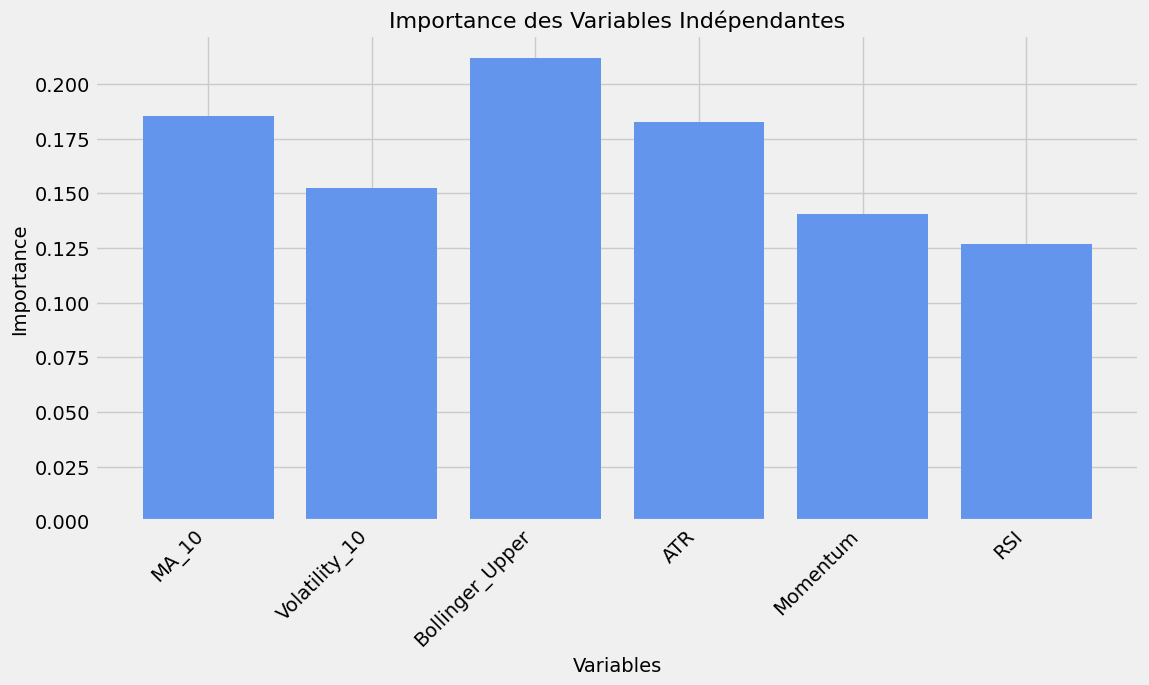

In [ ]:
feature_importances = xgb_model.feature_importances_
print(feature_importances)
plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_importances)), feature_importances, tick_label=features, color='cornflowerblue')
plt.xticks(rotation=45, ha='right')
plt.title("Importance des Variables Indépendantes", fontsize=16)
plt.xlabel("Variables", fontsize=14)
plt.ylabel("Importance", fontsize=14)
plt.show()

- Les valeurs d'importance sont relativement homogènes, aucune feature n'a une importance extrêmement faible (par exemple, proche de 0).
- Cela suggère que toutes les variables contribuent de manière significative aux performances du modèle.

Cependant, pour affiner le modèle, nous pourrions tester un modèle réduit en supprimant les variables avec une importance légèrement inférieure. Cela permettra de vérifier si la simplification améliore la performance ou réduit le bruit dans les prédictions.

Par exemple, nous constatons que certaines variables, comme Momentum (0.1175) et Volatility_10 (0.1237), ont une importance légèrement inférieure par rapport aux autres.

Entraînons de nouveau le modèle en supprimant ces features afin de comparer les métriques !

In [ ]:
new_features = ['MA_10', 'Bollinger_Upper', 'ATR', 'RSI']

X_train_new = X_train[new_features]
X_test_new = X_test[new_features]

xgb_model_new = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
random_search_new = RandomizedSearchCV(
    estimator=xgb_model_new,
    param_distributions=params,
    scoring='roc_auc',
    n_iter=20,
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)
random_search_new.fit(X_train_new, y_train)
best_xgb_model_2 = random_search_new.best_estimator_
y_pred_2 = best_xgb_model_2.predict(X_test_new)
y_proba_2 = best_xgb_model_2.predict_proba(X_test_new)[:, 1]
auc_new = roc_auc_score(y_test, y_proba_2)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


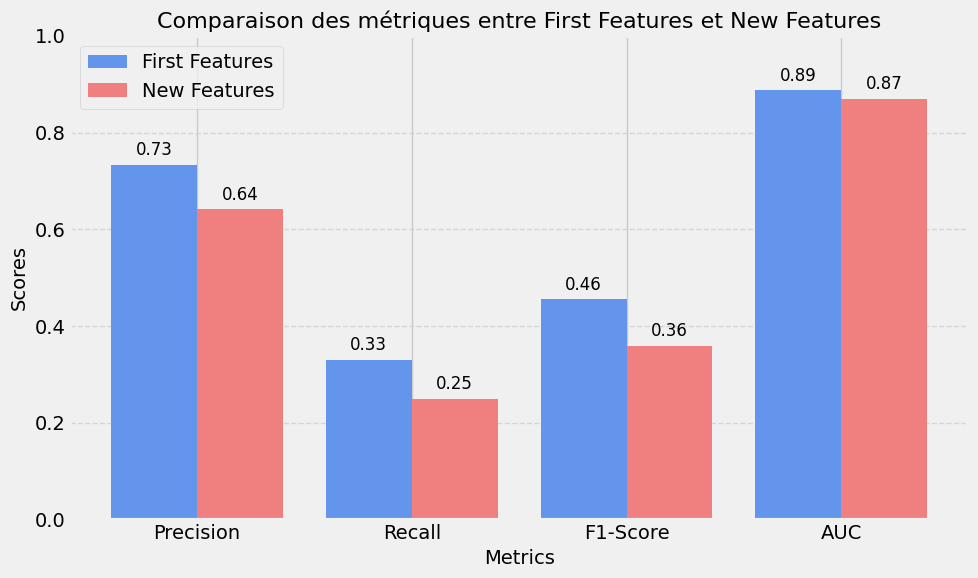

In [ ]:
precision_first = precision_score(y_test, y_pred_1)
recall_first = recall_score(y_test, y_pred_1)
f1_first = f1_score(y_test, y_pred_1)
auc_first = auc_base

precision_new = precision_score(y_test, y_pred_2)
recall_new = recall_score(y_test, y_pred_2)
f1_new = f1_score(y_test, y_pred_2)
auc_new = roc_auc_score(y_test, y_proba_2)

metrics = ["Precision", "Recall", "F1-Score", "AUC"]
first_features_scores = [precision_first, recall_first, f1_first, auc_first]
new_features_scores = [precision_new, recall_new, f1_new, auc_new]

x = range(len(metrics))

plt.figure(figsize=(10, 6))
plt.bar(x, first_features_scores, width=0.4, label="First Features", align='center', color='cornflowerblue')
plt.bar([p + 0.4 for p in x], new_features_scores, width=0.4, label="New Features", align='center', color='lightcoral')

plt.xlabel("Metrics", fontsize=14)
plt.ylabel("Scores", fontsize=14)
plt.title("Comparaison des métriques entre First Features et New Features", fontsize=16)
plt.xticks([p + 0.2 for p in x], metrics)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, (first, new) in enumerate(zip(first_features_scores, new_features_scores)):
    plt.text(i, first + 0.02, f"{first:.2f}", ha='center', fontsize=12, color='black')
    plt.text(i + 0.4, new + 0.02, f"{new:.2f}", ha='center', fontsize=12, color='black')

plt.tight_layout()
plt.show()


#### Analyse de la Comparaison des Métriques entre First Features et New Features

Le graphique présente une comparaison des performances entre les **features initiales** (First Features) et les **nouvelles features réduites** (New Features) selon quatre métriques : Précision, Rappel, F1-Score et AUC.

---

#### Observations :
1. **Précision** :
   - Les features initiales atteignent une précision de **0.73**, supérieure aux nouvelles features (**0.64**).
   - Cela montre que les features initiales sont plus fiables pour prédire les signaux d'achat (classe 1) correctement.

2. **Rappel** :
   - Le rappel est plus faible pour les nouvelles features (**0.25**) par rapport aux features initiales (**0.33**).
   - Cela signifie que les nouvelles features manquent davantage de hausses réelles, indiquant un risque accru de faux négatifs.

3. **F1-Score** :
   - L'équilibre entre précision et rappel est représenté par le F1-Score, qui est également plus élevé pour les features initiales (**0.46**) que pour les nouvelles features (**0.36**).
   - Les nouvelles features souffrent donc d'une diminution globale d'efficacité prédictive.

4. **AUC** :
   - L'AUC est similaire pour les deux modèles, avec une légère supériorité des features initiales (**0.89** contre **0.87**).
   - Cela montre que les nouvelles features, bien que simplifiées, conservent une capacité importante à distinguer les classes positives et négatives.

---

#### Interprétation :
Les features initiales offrent des performances globalement meilleures, particulièrement en termes de rappel et F1-Score.



# Bonus 1 : Quelques visualisations, que j'étais curieuse d'étudier en voyant le dataset



### 1. Volatilité Temporelle

Je pense qu'il serait intéressant de visualiser la volatilité des rendements sur une période glissante pour identifier les périodes de forte ou faible volatilité. Les périodes de forte volatilité peuvent indiquer des opportunités d'achat ou de vente, tandis que les périodes de faible volatilité reflètent un marché plus stable. Cela nous aide à anticiper les moments où le marché est plus risqué ou plus opportuniste.


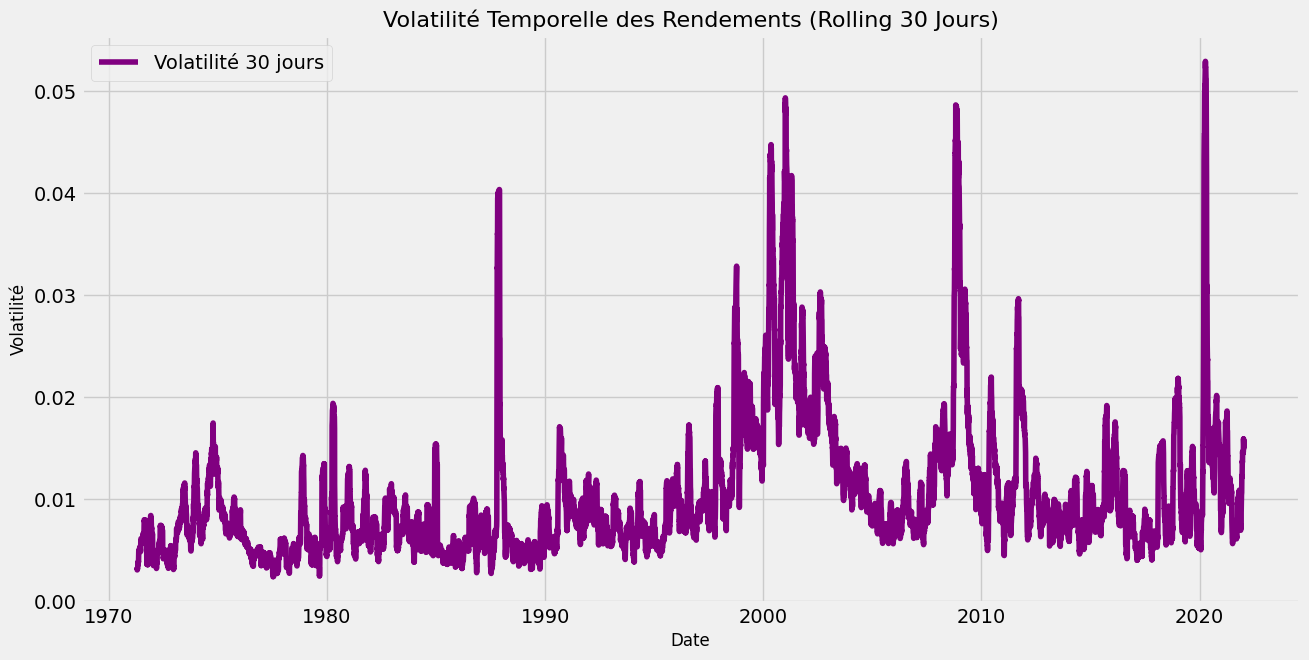

In [ ]:
plt.figure(figsize=(14, 7))
df['Rolling_Volatility'] = df['Returns'].rolling(window=30).std()
plt.plot(df['Rolling_Volatility'], color='purple', label='Volatilité 30 jours')
plt.title("Volatilité Temporelle des Rendements (Rolling 30 Jours)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Volatilité", fontsize=12)
plt.grid(True)
plt.legend()
plt.show()


**Obervations et interprétations : **

1. **1987 (Lundi Noir)** :
   - Une volatilité extrêmement élevée est observée en 1987, correspondant au krach boursier connu sous le nom de "lundi noir". Ce fut une chute brutale et rapide des marchés, marquée par une perte de confiance des investisseurs.

2. **2000–2002 (Bulle Internet)** :
   - La volatilité augmente fortement durant cette période, marquant l'explosion de la bulle Internet. La chute des valeurs technologiques a provoqué des mouvements de marché importants et une incertitude prolongée.

3. **2007–2009 (Crise Financière Mondiale)** :
   - Une des périodes les plus marquantes de volatilité élevée. La crise des subprimes a entraîné des mouvements extrêmes sur les marchés, avec des pertes massives et des rebonds ponctuels.

4. **2020 (Pandémie de COVID-19)** :
   - Une forte volatilité est enregistrée en 2020, reflet de l'incertitude et de la peur provoquées par la pandémie de COVID-19. Les marchés ont initialement chuté fortement avant de connaître une reprise rapide, alimentée par les politiques monétaires et fiscales.

---

**Périodes de Volatilité Modérée**
- Les périodes de volatilité modérée, comme les années 1990 avant la bulle Internet, ou les années 2010 après la crise financière, reflètent des marchés plus stables et moins marqués par des événements exceptionnels.




### 2. Cible vs Rendements

Je pense qu'il serait pertinent de comparer la distribution des rendements pour les classes 0 (pas d'achat) et 1 (achat). Cela permet de mieux comprendre les différences entre les périodes où l'on devrait acheter et celles où l'on ne devrait pas. Si les distributions diffèrent nettement, cela confirmerait que la variable `Target` est bien construite et reflète des comportements de marché spécifiques.


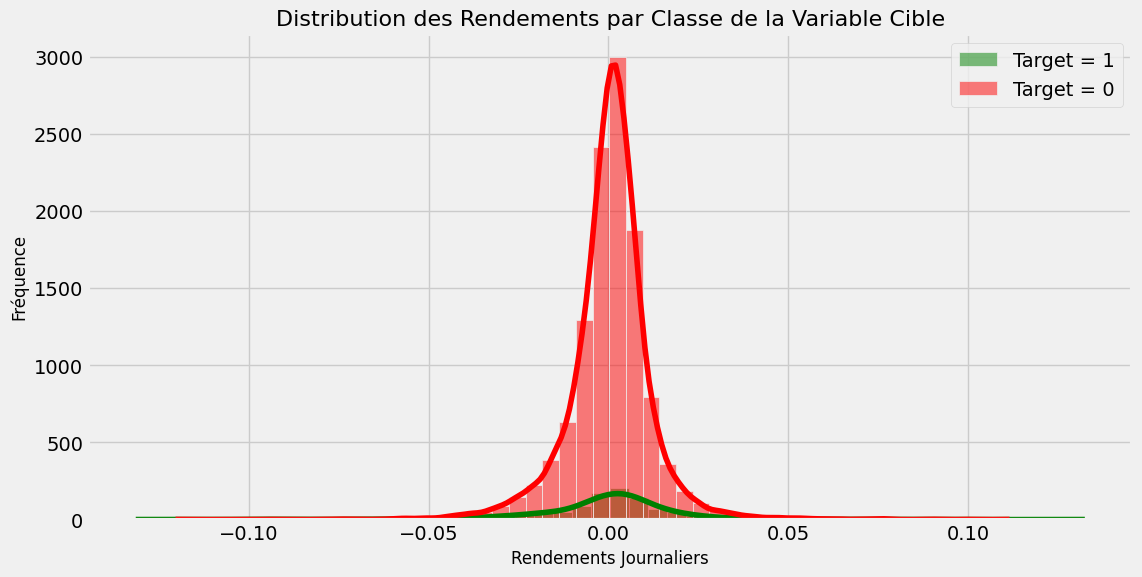

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(df[df['Target'] == 1]['Returns'], bins=50, color='green', label='Target = 1', kde=True)
sns.histplot(df[df['Target'] == 0]['Returns'], bins=50, color='red', label='Target = 0', kde=True)
plt.title("Distribution des Rendements par Classe de la Variable Cible", fontsize=16)
plt.xlabel("Rendements Journaliers", fontsize=12)
plt.ylabel("Fréquence", fontsize=12)
plt.legend()
plt.show()


**Observations et Interprétations**

1. **Distribution Centrée autour de Zéro** :
   - La majorité des rendements journaliers, pour les deux classes, sont concentrés autour de 0. Cela montre que les rendements journaliers suivent une distribution normale, avec peu de mouvements extrêmes dans les deux directions.

2. **Classes Déséquilibrées** :
   - La distribution pour **Target = 0** (en rouge) est nettement plus large et plus fréquente, indiquant que les jours où aucune hausse significative est prévue sont beaucoup plus nombreux.
   - En revanche, les observations avec **Target = 1** (en vert) sont rares, ce qui reflète la difficulté de prévoir des hausses importantes.

3. **Queue de Distribution pour Target = 1** :
   - La classe **Target = 1** a tendance à apparaître dans les queues de la distribution, ce qui signifie que ces événements sont associés à des rendements positifs plus élevés. Cela correspond à des hausses rares mais marquées.

---

**Importance pour la Décision d'Achat**
- **Rareté des Événements** :
  - Les jours marqués comme "Target = 1" sont rares, ce qui signifie qu'investir dans le Nasdaq en anticipation de telles hausses nécessite un modèle prédictif robuste pour éviter les faux positifs.
- **Différenciation des Classes** :
  - La distinction visuelle entre les distributions des deux classes souligne l'importance des indicateurs avancés pour prédire ces mouvements rares mais significatifs.

### 3. Comparaison des Performances des Moyennes Mobiles

Je pense qu'il serait utile d'observer comment les moyennes mobiles (10 jours et 50 jours) interagissent avec le prix de clôture. Les croisements entre ces moyennes et le prix de clôture peuvent indiquer des signaux d'achat ou de vente, selon les tendances du marché. Cela nous aide à évaluer si ces indicateurs peuvent être des éléments prédictifs pour notre modèle.


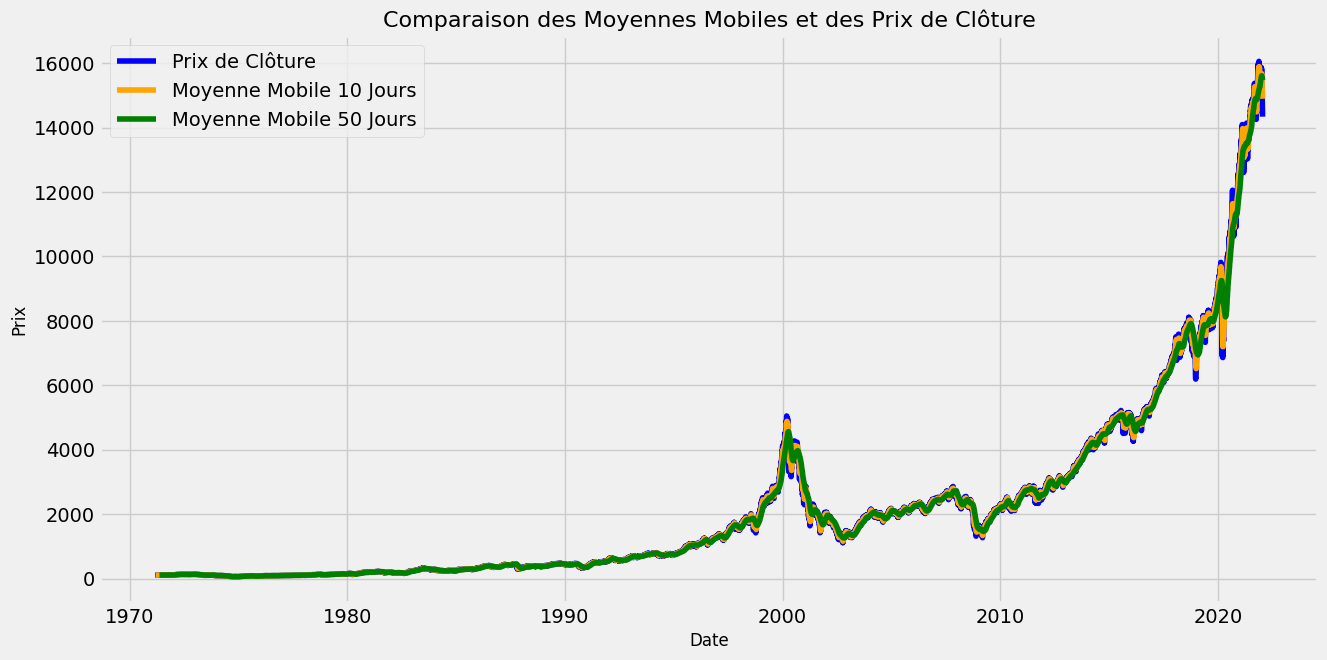

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(df['Adj Close'], label='Prix de Clôture', color='blue')
plt.plot(df['MA_10'], label='Moyenne Mobile 10 Jours', color='orange')
plt.plot(df['MA_50'], label='Moyenne Mobile 50 Jours', color='green')
plt.title("Comparaison des Moyennes Mobiles et des Prix de Clôture", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Prix", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


**Obervations et interprétations**

1. **Suivi des Tendances** :
   - La moyenne mobile sur **10 jours** suit de près les variations des prix de clôture, réagissant rapidement aux fluctuations à court terme.
   - La moyenne mobile sur **50 jours** est plus lissée et met en évidence les tendances à moyen terme.

2. **Points de Croisement (Crossovers)** :
   - Lorsque la moyenne mobile sur 10 jours croise la moyenne mobile sur 50 jours vers le haut, cela peut signaler une tendance haussière (achat potentiel).
   - À l'inverse, un croisement vers le bas peut indiquer une tendance baissière (vente potentielle).

3. **Tendances Long-Terme** :
   - Les prix montrent une augmentation soutenue à long terme, particulièrement marquée après les années 2000, reflétant la croissance des valeurs technologiques.

---

**Utilité pour Décider d'Acheter ou Vendre le Nasdaq**
- **Analyse des Crossovers** :
  - Les croisements entre les moyennes mobiles permettent d’identifier des signaux d'achat ou de vente potentiels.
- **Confirmation des Tendances** :
  - Les moyennes mobiles aident à filtrer le "bruit" des fluctuations journalières et à se concentrer sur les tendances majeures.

### 4. Analyse des Anomalies avec l'ATR

Je pense qu'il serait intéressant d'utiliser l'ATR pour observer les périodes où les prix dépassent les plages normales. Ces anomalies peuvent indiquer des moments où le marché est en mouvement extrême, ce qui peut être crucial pour prendre des décisions d'achat ou de vente. L'ATR peut également aider à évaluer la fiabilité des tendances actuelles.


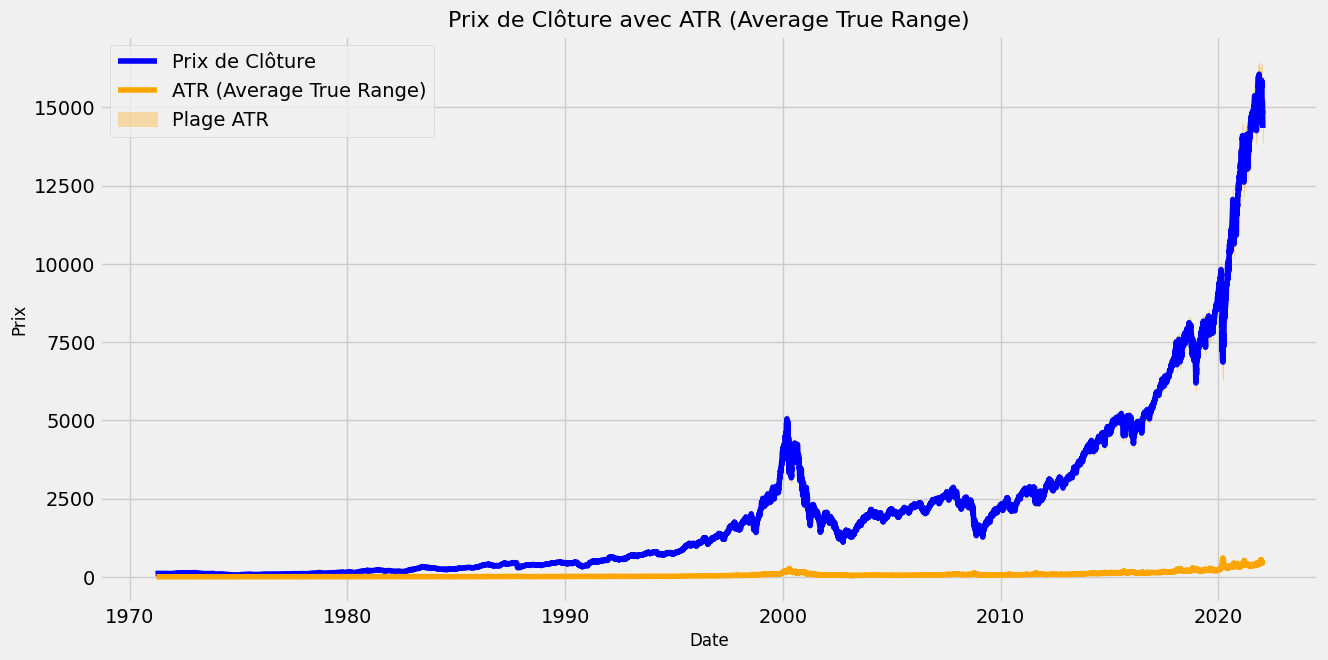

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(df['Adj Close'], label='Prix de Clôture', color='blue')
plt.plot(df['ATR'], label='ATR (Average True Range)', color='orange')
plt.fill_between(df.index, df['Adj Close'] - df['ATR'], df['Adj Close'] + df['ATR'], color='orange', alpha=0.3, label='Plage ATR')
plt.title("Prix de Clôture avec ATR (Average True Range)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Prix", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


**Obervations et Interprétations**

1. **Volatilité et Prix de Clôture** :
   - L'ATR reste relativement stable pendant les périodes de faible volatilité, comme les années 1980 ou les années postérieures à 2010 (jusqu'au COVID-19).
   - Les périodes de volatilité accrue, comme pendant la bulle Internet (2000) ou la crise financière de 2008, montrent une hausse marquée de l'ATR.

2. **Utilité de la Plage ATR** :
   - La plage ATR met en évidence la "zone normale" de fluctuation des prix, ce qui peut être utilisé pour définir des points d'entrée et de sortie, ou pour ajuster des seuils de stop-loss dynamiques.

3. **Pic de Volatilité en 2020 (COVID-19)** :
   - Une augmentation significative de l'ATR est observée en 2020, indiquant l'incertitude extrême liée à la pandémie.

---

**Utilité pour Décider d'Acheter ou de Vendre**
- **Gestion du Risque** :
  - Un ATR élevé indique une période de volatilité accrue, où les risques et les opportunités sont plus importants.
- **Stratégie Stop-Loss** :
  - L'ATR peut être utilisé pour placer des seuils de stop-loss adaptés à la volatilité actuelle du marché, réduisant ainsi les sorties prématurées.


### 5. Évolution de l'Indice RSI

Je pense qu'il serait pertinent de visualiser l'indice RSI pour identifier les zones de surachat (RSI > 70) et de survente (RSI < 30). Ces zones peuvent être utilisées pour détecter les moments où le marché est potentiellement surévalué ou sous-évalué, fournissant ainsi des signaux d'achat ou de vente.


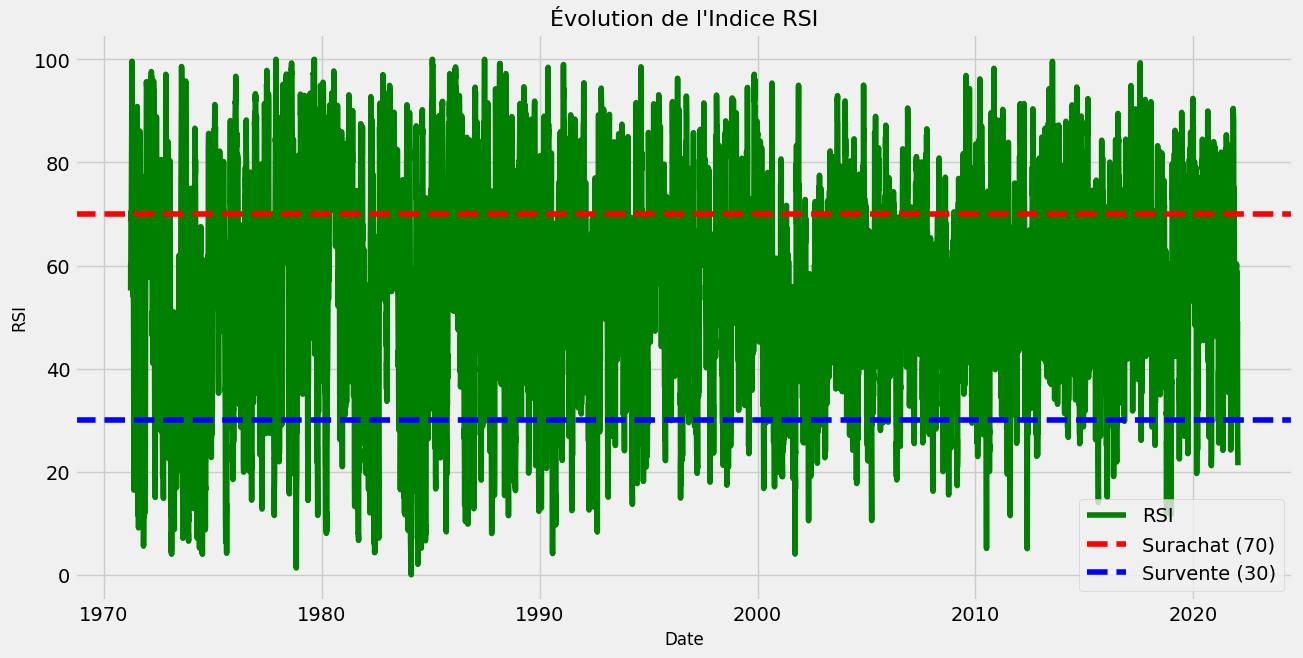

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(df['RSI'], label='RSI', color='green')
plt.axhline(70, color='red', linestyle='--', label='Surachat (70)')
plt.axhline(30, color='blue', linestyle='--', label='Survente (30)')
plt.title("Évolution de l'Indice RSI", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("RSI", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


Il est tout de même assez difficile de détecter quoi que ce soit. Dans le prochain code, nous allons nous concentrer sur trois périodes : avant les années 2000, de 2000 à 2010, et à partir de 2010.

In [ ]:
def plot_rsi(start_date, end_date):
    clear_output(wait=True)
    filtered_df = df.loc[start_date:end_date]
    plt.figure(figsize=(14, 7))
    plt.plot(filtered_df['RSI'], label='RSI', color='green')
    plt.axhline(70, color='red', linestyle='--', label='Surachat (70)')
    plt.axhline(30, color='blue', linestyle='--', label='Survente (30)')
    plt.title(f"Évolution de l'Indice RSI ({start_date} à {end_date})", fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("RSI", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()
    display(button_box)


button1 = widgets.Button(description='Avant 2000')
button2 = widgets.Button(description='2000 à 2010')
button3 = widgets.Button(description='2010 à Fin')

def on_button1_clicked(b):
    plot_rsi('1971-01-01', '2000-01-01')

def on_button2_clicked(b):
    plot_rsi('2000-01-01', '2010-01-01')

def on_button3_clicked(b):
    plot_rsi('2010-01-01', '2022-01-19')

button1.on_click(on_button1_clicked)
button2.on_click(on_button2_clicked)
button3.on_click(on_button3_clicked)

button_box = widgets.HBox([button1, button2, button3])
display(button_box)


Ici, c'est tout de même un peu mieux, mais il reste difficile de détecter les grands changements. Pour aller plus loin, je me suis demandé quelles étaient les dates les plus importantes qui pourraient avoir un impact sur l'indice RSI. J'ai donc effectué des recherches sur Internet pour en savoir plus, et voici ce qui en est ressorti :

Chaque bouton correspond à une période spécifique marquée par des événements majeurs :

- **[1971-1990](https://en.wikipedia.org/wiki/Nasdaq)** : Les débuts du Nasdaq, avec des phases de croissance initiale.
- **[1995-2002](https://en.wikipedia.org/wiki/Dot-com_bubble)** : La bulle Internet et son explosion.
- **[2007-2009](https://en.wikipedia.org/wiki/Financial_crisis_of_2007–2008)** : La crise financière mondiale.
- **[2010-2020](https://en.wikipedia.org/wiki/Technology_sector)** : L'essor des valeurs technologiques.

In [ ]:
df['Year'] = df.index.year
annual_returns = df.groupby('Year')['Returns'].sum()

def plot_annual_returns(start_year, end_year):
    clear_output(wait=True)
    period_returns = annual_returns.loc[start_year:end_year]
    plt.figure(figsize=(14, 7))
    plt.bar(period_returns.index, period_returns.values, color='blue', alpha=0.7)
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.title(f"Rendements Annuels du Nasdaq ({start_year}-{end_year})", fontsize=16)
    plt.xlabel("Années", fontsize=12)
    plt.ylabel("Rendement Annuel", fontsize=12)
    plt.grid(True)
    plt.show()
    display(button_box)

button1 = widgets.Button(description='1971-1990 (Débuts)')
button2 = widgets.Button(description='1995-2002 (Bulle Internet)')
button3 = widgets.Button(description='2007-2009 (Crise Financière)')
button4 = widgets.Button(description='2010-2020 (Essor Technologique)')
button5 = widgets.Button(description='2019-2022 (COVID-19)')

def on_button1_clicked(b):
    plot_annual_returns(1971, 1990)

def on_button2_clicked(b):
    plot_annual_returns(1995, 2002)

def on_button3_clicked(b):
    plot_annual_returns(2007, 2009)

def on_button4_clicked(b):
    plot_annual_returns(2010, 2020)

def on_button5_clicked(b):
    plot_annual_returns(2019, 2022)

button1.on_click(on_button1_clicked)
button2.on_click(on_button2_clicked)
button3.on_click(on_button3_clicked)
button4.on_click(on_button4_clicked)
button5.on_click(on_button5_clicked)

button_box = widgets.HBox([button1, button2, button3, button4, button5])
display(button_box)


**Observations et Interprétations**

**Graphique 1 :** Rendements Annuels du Nasdaq (1971-1990)
Ce graphique met en évidence les variations annuelles de rendement du Nasdaq durant ses premières années. On observe des années de forte croissance dans les années 1980, mais aussi des périodes de déclin, comme en 1973-1974, dues à des crises économiques globales comme le choc pétrolier.

**Graphique 2 :** Rendements Annuels du Nasdaq (1995-2002)
Cette période inclut la montée spectaculaire liée à la bulle Internet, culminant en 1999 avec des rendements exceptionnels. Cependant, l'éclatement de cette bulle est visible avec des baisses drastiques dès 2000, indiquant des pertes massives pour les investisseurs.

**Graphique 3 :** Rendements Annuels du Nasdaq (2007-2009)
Ce graphique illustre l'impact de la crise financière de 2008. On observe une chute drastique du Nasdaq en 2008, suivie d'un rebond important en 2009, marquant une reprise économique progressive.

**Graphique 4 :** Rendements Annuels du Nasdaq (2010-2020)
Après la crise de 2008, cette décennie montre une reprise constante, avec des années de forte croissance comme 2013 et 2020. La volatilité reste modérée, excepté en 2018 avec une baisse notable due à des incertitudes économiques.

**Graphique 5 :** Rendements Annuels du Nasdaq (2019-2022)
Ce graphique montre les fluctuations du Nasdaq durant la pandémie de COVID-19. Malgré une chute initiale en 2020, le marché a connu un rebond rapide grâce à des politiques monétaires accommodantes et à la montée en puissance des valeurs technologiques.

### 6. Impact des Variables Indépendantes sur les Prédictions

Je pense qu'il serait utile de comparer les valeurs des variables indépendantes entre les classes `Target = 0` et `Target = 1`. Cela permet de voir si certaines variables influencent fortement la décision d'achat ou non. Par exemple, des différences significatives dans les moyennes mobiles ou le RSI entre les deux classes pourraient indiquer leur pertinence pour les prédictions.

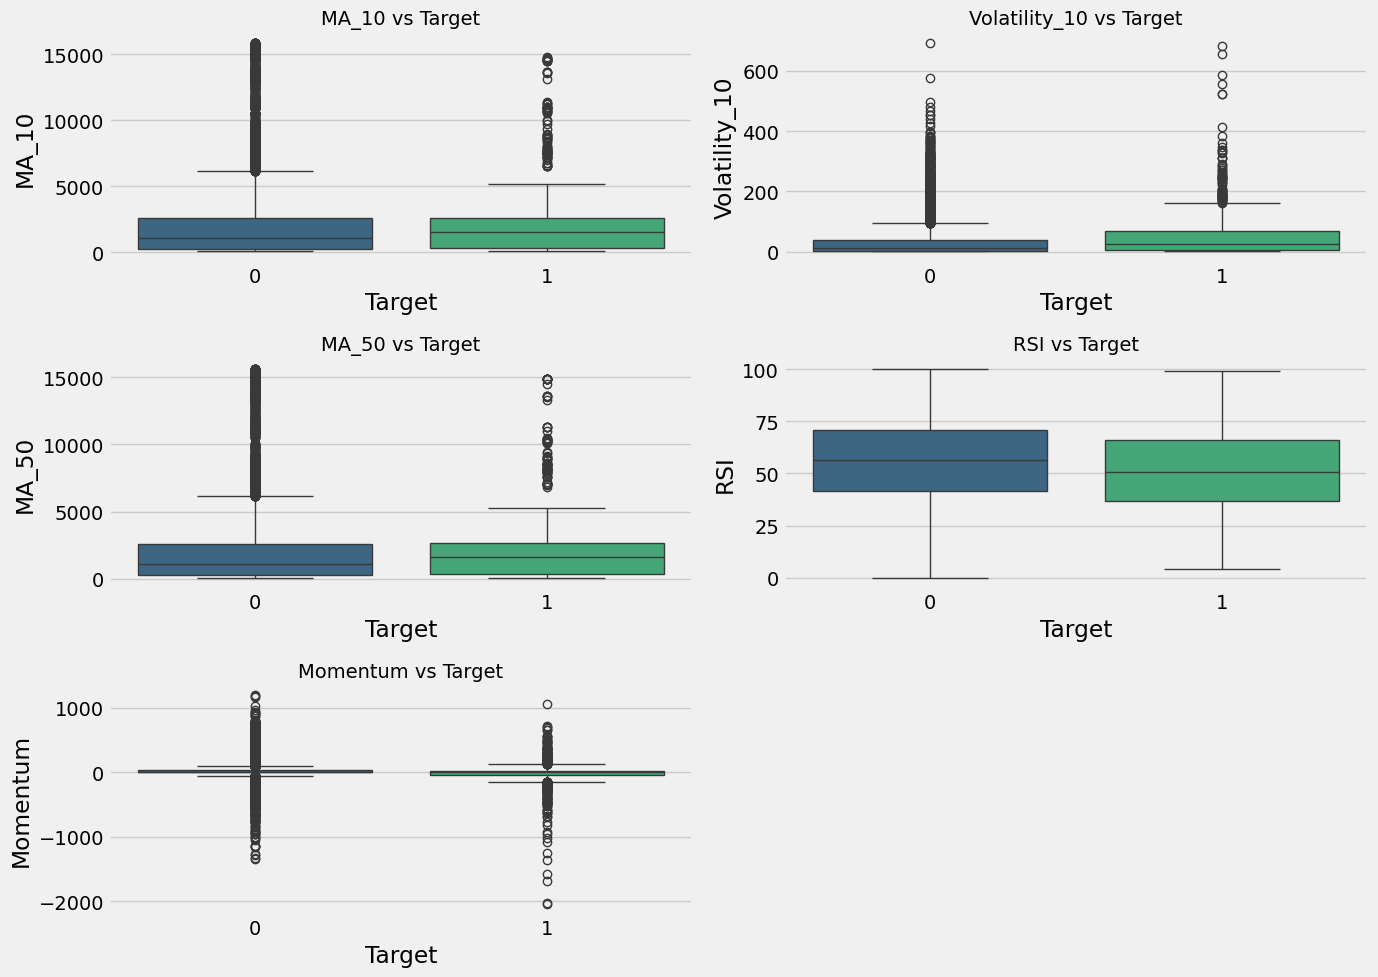

In [ ]:
variables = ['MA_10', 'Volatility_10', 'MA_50', 'RSI', 'Momentum']
plt.figure(figsize=(14, 10))
for i, var in enumerate(variables, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x='Target', y=var, data=df, palette='viridis')
    plt.title(f"{var} vs Target", fontsize=14)
    plt.xlabel("Target")
    plt.ylabel(var)
plt.tight_layout()
plt.show()


**Observations et Interpretations**

Les boîtes à moustaches présentent la distribution de certaines variables (MA_10, Volatility_10, MA_50, Momentum, RSI) en fonction de la variable cible (Target = 0 ou 1). Ces visualisations permettent d'évaluer si ces variables différencient clairement les cas où le Nasdaq est en hausse (+5 %) (Target = 1) ou non (Target = 0).

- **MA_10 et MA_50 (Moyennes Mobiles)** : Les distributions sont similaires entre Target = 0 et Target = 1, ce qui suggère que ces indicateurs ne différencient pas fortement les situations d'achat potentiel.
- **Volatility_10 (Volatilité sur 10 jours)** : La volatilité est légèrement plus élevée pour Target = 1, mais l'effet reste limité.
- **Momentum** : Bien que la distribution soit assez homogène, il semble y avoir une tendance à des valeurs plus positives pour Target = 1, ce qui reflète un élan haussier des prix.
- **RSI (Relative Strength Index)** : On observe que le RSI est plus élevé pour Target = 1, ce qui est cohérent avec un signal de surachat souvent lié à une hausse des prix.



# Bonus 2 : Comparons notre modèle XGBoost avec le modèle RandomnForest

In [ ]:
X = df[['MA_10', 'Volatility_10', 'Bollinger_Upper', 'ATR', 'Momentum', 'RSI']]
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train = X_train.dropna()
y_train = y_train[X_train.index]

X_test = X_test.dropna()
y_test = y_test[X_test.index]



In [ ]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

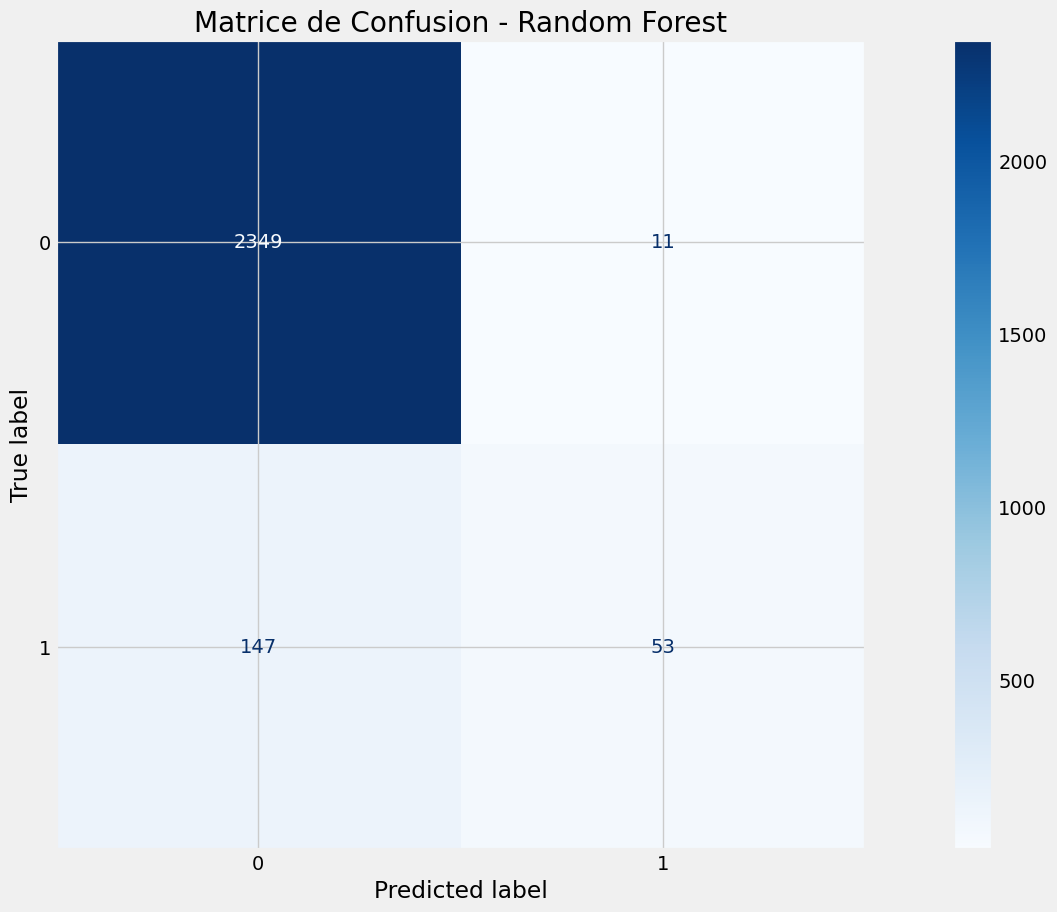

Précision: 0.83
Rappel: 0.27
F1-Score: 0.40
AUC-ROC: 0.90


In [ ]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf_model.classes_)
disp_rf.plot(cmap="Blues")
plt.title("Matrice de Confusion - Random Forest")
plt.show()

precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
auc_roc_rf = roc_auc_score(y_test, y_proba_rf)

print(f"Précision: {precision_rf:.2f}")
print(f"Rappel: {recall_rf:.2f}")
print(f"F1-Score: {f1_rf:.2f}")
print(f"AUC-ROC: {auc_roc_rf:.2f}")


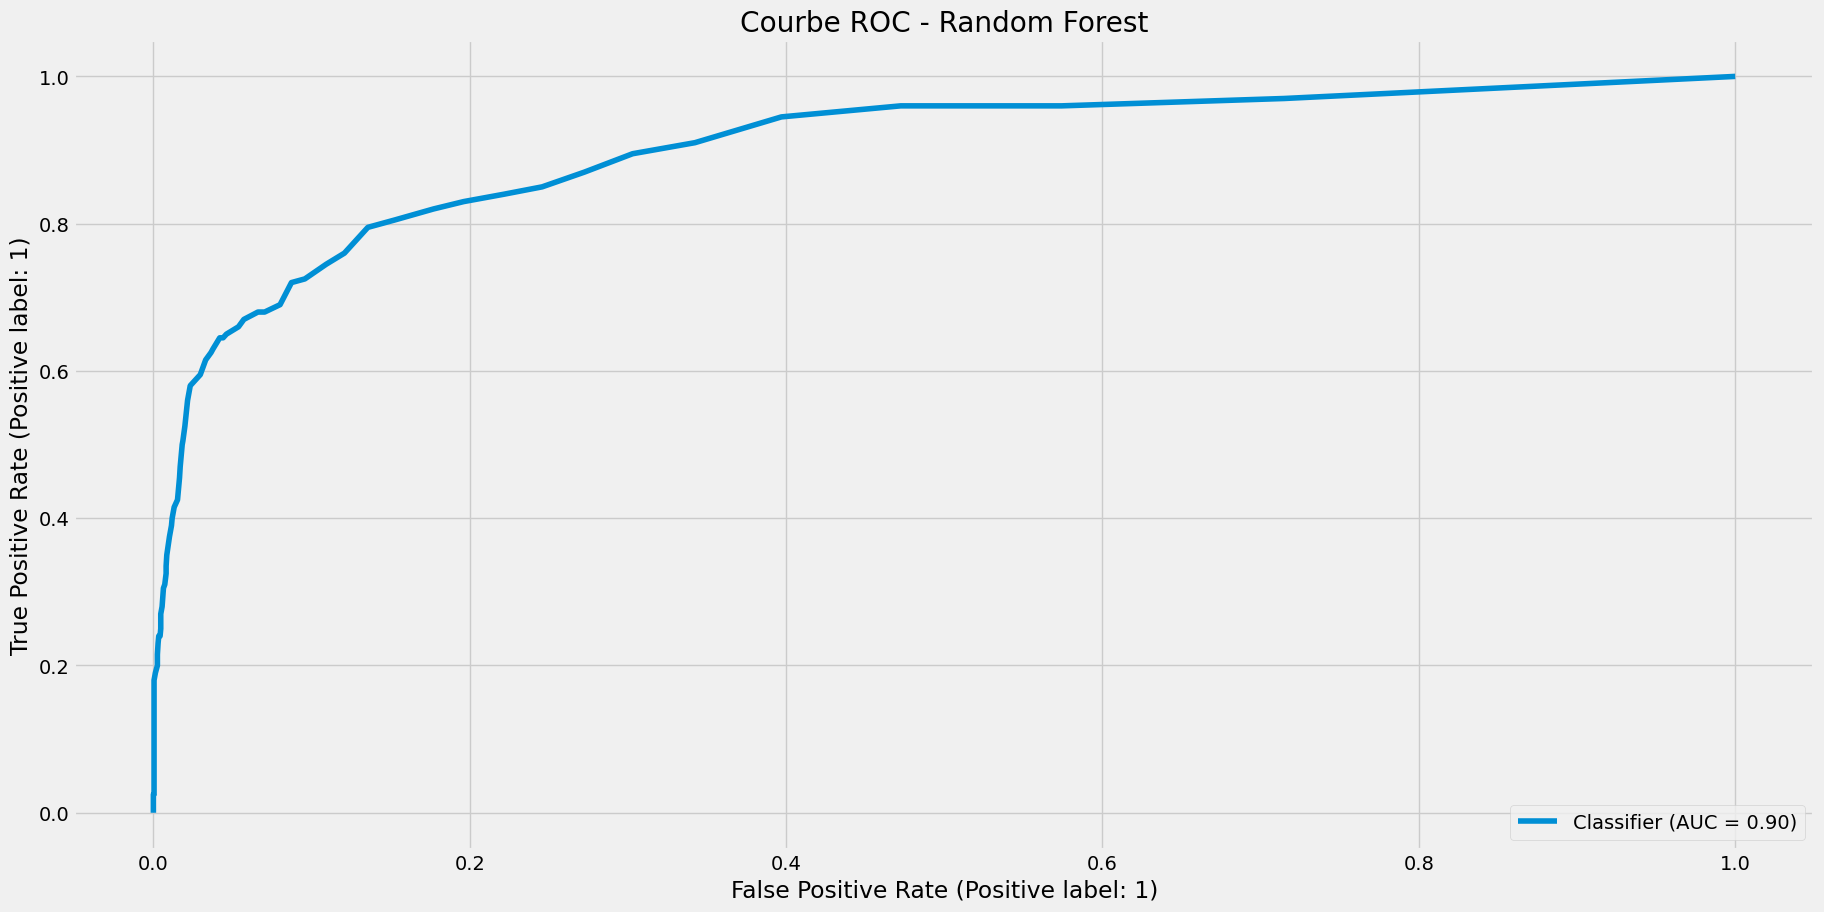

In [ ]:
RocCurveDisplay.from_predictions(y_test, y_proba_rf)
plt.title("Courbe ROC - Random Forest")
plt.show()


### Testons en cherchant les meilleurs hyperparamètres : RandomizedSearchCV

In [ ]:
param_grid_rf = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

random_search_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_grid_rf,
    n_iter=50,
    scoring='accuracy',
    n_jobs=-1,
    cv=5,
    verbose=3,
    random_state=42
)

random_search_rf.fit(X_train, y_train)

best_rf_model = random_search_rf.best_estimator_
y_pred_rf_optimized = best_rf_model.predict(X_test)
y_proba_rf_optimized = best_rf_model.predict_proba(X_test)[:, 1]

metrics_rf = {
    "Precision": precision_score(y_test, y_pred_rf_optimized),
    "Recall": recall_score(y_test, y_pred_rf_optimized),
    "F1-Score": f1_score(y_test, y_pred_rf_optimized),
    "AUC-ROC": roc_auc_score(y_test, y_proba_rf_optimized)
}

print("\nRapport de classification pour Random Forest optimisé :\n", classification_report(y_test, y_pred_rf_optimized))


Fitting 5 folds for each of 50 candidates, totalling 250 fits

Rapport de classification pour Random Forest optimisé :
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      2360
           1       0.78      0.42      0.55       200

    accuracy                           0.95      2560
   macro avg       0.87      0.70      0.76      2560
weighted avg       0.94      0.95      0.94      2560



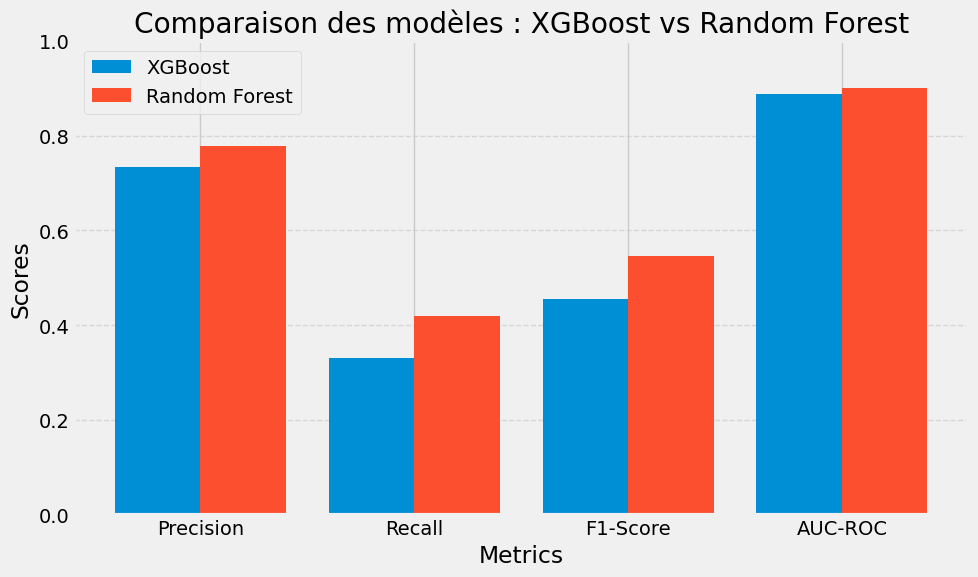

In [ ]:
metrics_xgb = metrics_results["RandomizedSearch"]

models = ["XGBoost", "Random Forest"]
metrics = ["Precision", "Recall", "F1-Score", "AUC-ROC"]

xgb_values = [metrics_xgb[metric] for metric in metrics]
rf_values = [metrics_rf[metric] for metric in metrics]

x = range(len(metrics))

plt.figure(figsize=(10, 6))
plt.bar(x, xgb_values, width=0.4, label="XGBoost", align='center')
plt.bar([p + 0.4 for p in x], rf_values, width=0.4, label="Random Forest", align='center')

plt.xlabel("Metrics")
plt.ylabel("Scores")
plt.title("Comparaison des modèles : XGBoost vs Random Forest")
plt.xticks([p + 0.2 for p in x], metrics)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**Random Forest est clairement le meilleur modèle**, car il surpasse XGBoost en précision, rappel, F1-Scoree et AUC-ROC. Ces résultats montrent que Random Forest est mieux adapté pour identifier les opportunités d'achat tout en maintenant un équilibre entre prédictions correctes et erreurs.